# Описание проекта

### Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

#### План действий 

- Подготовить имеющиеся данные для обучения
- Разработать модель, которая предскажет вероятность снижения покупательской активности
- Выделить сегмент покупателей и разработать персонализированные предложения, чтобы увеличить их покупательскую активность

## Шаг 1. Загрузка и обзор данных

In [6]:
pip install --upgrade scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install phik


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install shap


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import shap
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

In [10]:
file_paths = [
    ('market_file.csv', ','), 
    ('market_money.csv', ','), 
    ('market_time.csv', ','), 
    ('money.csv', ';')
]

# Список имен датафреймов
df_names = ['df_market_file', 'df_market_money', 'df_market_time', 'df_money']

# Загрузка данных с обработкой исключений
for i, (file_name, sep) in enumerate(file_paths):
    try:
        df = pd.read_csv(file_name, sep=sep, decimal='.' if sep == ',' else ',')
    except:
        df = pd.read_csv(f'/datasets/{file_name}', sep=sep, decimal='.' if sep == ',' else ',')
    
    # Динамически создаем переменные с именами из df_names
    globals()[df_names[i]] = df

# Функция для первичного изучения всех датафреймов
for df_name in df_names:
    df = globals()[df_name]  # Получаем датафрейм по имени
    print(f'\nИзучение данных датафрейма "{df_name}"\n')
    print(f'Размер: {df.shape[0]} строк, {df.shape[1]} столбцов\n')
    print(f'Первые 5 строк датафрейма "{df_name}"\n')
    display(df.head(5))
    print(f'Общая информация о "{df_name}"\n')
    df.info()  # Информация о типах данных и пропусках
    print('\n' + '-' * 50 + '\n')


Изучение данных датафрейма "df_market_file"

Размер: 1300 строк, 13 столбцов

Первые 5 строк датафрейма "df_market_file"



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Общая информация о "df_market_file"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Общая информация о "df_market_money"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

--------------------------------------------------


Изучение данных датафрейма "df_market_time"

Размер: 2600 строк, 3 столбцов

Первые 5 строк датафрейма "df_market_time"



,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Общая информация о "df_market_time"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

--------------------------------------------------


Изучение данных датафрейма "df_money"

Размер: 1300 строк, 2 столбцов

Первые 5 строк датафрейма "df_money"



,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Общая информация о "df_money"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

--------------------------------------------------



- Загрузили и посмотрели на данные.
- Даннын Соответствуют описанию
- Далее проделаем необходимую предобработку данных

## Шаг 2. Предобработка данных

In [13]:
# Приводим столбцы к нижнему регистру и заменяем пробелы на подчеркивания
df_market_file.columns = df_market_file.columns.str.lower().str.replace(' ', '_')
df_market_money.columns = df_market_money.columns.str.lower().str.replace(' ', '_')
df_market_time.columns = df_market_time.columns.str.lower().str.replace(' ', '_')
df_money.columns = df_money.columns.str.lower().str.replace(' ', '_')

# Выводим названия столбцов каждого датафрейма
for df in [df_market_file, df_market_money, df_market_time, df_money]:
    print(f'Столбцы датафрейма:\n')
    for column in df.columns:
        print(column)
    print('-' * 50 + '\n')  # Разделитель для читаемости


Столбцы датафрейма:

id
покупательская_активность
тип_сервиса
разрешить_сообщать
маркет_актив_6_мес
маркет_актив_тек_мес
длительность
акционные_покупки
популярная_категория
средний_просмотр_категорий_за_визит
неоплаченные_продукты_штук_квартал
ошибка_сервиса
страниц_за_визит
--------------------------------------------------

Столбцы датафрейма:

id
период
выручка
--------------------------------------------------

Столбцы датафрейма:

id
период
минут
--------------------------------------------------

Столбцы датафрейма:

id
прибыль
--------------------------------------------------



In [14]:
# Список датафреймов и их имена
df_list = [df_market_file, df_market_money, df_market_time, df_money]
#df_names = ['df_market_file', 'df_market_money', 'df_market_time', 'df_money']

# Поиск пропущенных значений в каждом столбце каждого датафрейма
for i, df in enumerate(df_list):
    print(f'\nПропущенные значения в датафрейме "{df_names[i]}":\n')
    print(df.isna().sum())  # Выводим количество пропущенных значений для каждого столбца
    print('-' * 50)



Пропущенные значения в датафрейме "df_market_file":

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
--------------------------------------------------

Пропущенные значения в датафрейме "df_market_money":

id         0
период     0
выручка    0
dtype: int64
--------------------------------------------------

Пропущенные значения в датафрейме "df_market_time":

id        0
период    0
минут     0
dtype: int64
--------------------------------------------------

Пропущенные значения в датафрейме "d

In [15]:
# Список датафреймов и их имена
df_list = [df_market_file, df_market_money, df_market_time, df_money]
#df_names = ['df_market_file', 'df_market_money', 'df_market_time', 'df_money']

# Проверка типов данных в каждом датафрейме
for i, df in enumerate(df_list):
    print(f'\nТипы данных в датафрейме "{df_names[i]}":\n')
    print(df.dtypes)  # Выводим типы данных каждого столбца
    print('-' * 50)



Типы данных в датафрейме "df_market_file":

id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object
--------------------------------------------------

Типы данных в датафрейме "df_market_money":

id           int64
период      object
выручка    float64
dtype: object
--------------------------------------------------

Типы данных в датафрейме "df_market_time":

id         int64
период    object
минут      int64
dtype: object
-

In [16]:
df_list = [df_market_file, df_market_money, df_market_time, df_money]
for i, df in enumerate(df_list):
    print(f'\nРандомные 3 строки датафрейма "{df_names[i]}":\n')
    display(df.sample(3)) 
    print('-' * 50)



Рандомные 3 строки датафрейма "df_market_file":



,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1168,216516,Прежний уровень,стандарт,нет,5.4,4,508,0.28,Мелкая бытовая техника и электроника,3,1,3,8
604,215952,Прежний уровень,стандарт,да,4.9,4,869,0.24,Мелкая бытовая техника и электроника,3,1,4,8
441,215789,Прежний уровень,премиум,да,3.6,3,985,0.26,Мелкая бытовая техника и электроника,5,2,8,5


--------------------------------------------------

Рандомные 3 строки датафрейма "df_market_money":



,id,период,выручка
1780,215941,текущий_месяц,5192.4
307,215450,препредыдущий_месяц,4849.0
3852,216632,предыдущий_месяц,4946.5


--------------------------------------------------

Рандомные 3 строки датафрейма "df_market_time":



,id,период,минут
96,215396,текущий_месяц,6
712,215704,предыдцщий_месяц,9
888,215792,текущий_месяц,17


--------------------------------------------------

Рандомные 3 строки датафрейма "df_money":



,id,прибыль
637,215985,6.78
1034,216382,5.94
563,215911,5.26


--------------------------------------------------


In [17]:
df_list = [df_market_file, df_market_money, df_market_time, df_money]
for i, df in enumerate(df_list):
    print(f'\nДубликаты в датафрейме "{df_names[i]}":')
    
    # Проверяем на явные дубликаты
    duplicates = df[df.duplicated()]
    
    if not duplicates.empty:
        print(f'Найдено {duplicates.shape[0]} явных дубликатов:')
        display(duplicates.head(3))  # Показываем первые 3 строки дубликатов для примера
    else:
        print('Явных дубликатов не найдено.')
    
    print('-' * 50)



Дубликаты в датафрейме "df_market_file":
Явных дубликатов не найдено.
--------------------------------------------------

Дубликаты в датафрейме "df_market_money":
Явных дубликатов не найдено.
--------------------------------------------------

Дубликаты в датафрейме "df_market_time":
Явных дубликатов не найдено.
--------------------------------------------------

Дубликаты в датафрейме "df_money":
Явных дубликатов не найдено.
--------------------------------------------------


In [18]:
print('Проверка уникальных значений "df_market_file"\n')
for col in df_market_file.select_dtypes(exclude='number').columns:
    print(f'Уникальные значения столбца "{col}":\n')
    print(f'{df_market_file[col].value_counts()}\n')
    print(f'Количество уникальных значений столбца "{col}": {len(df_market_file[col].unique())}')
    print('-' * 50)  # Разделитель для читаемости

# Отдельно проверим столбец 'id'
print('\nКоличество уникальных значений столбца "id":', len(df_market_file['id'].unique()))


Проверка уникальных значений "df_market_file"

Уникальные значения столбца "покупательская_активность":

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Количество уникальных значений столбца "покупательская_активность": 2
--------------------------------------------------
Уникальные значения столбца "тип_сервиса":

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Количество уникальных значений столбца "тип_сервиса": 3
--------------------------------------------------
Уникальные значения столбца "разрешить_сообщать":

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

Количество уникальных значений столбца "разрешить_сообщать": 2
--------------------------------------------------
Уникальные значения столбца "популярная_категория":

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                  

-
В некоторых столбцах присутствуют строки с опечатками, например, в столбце период датафрейма df_market_time значении 'предыдцщий_месяц'.
Некоторые столбцы содержат только несколько уникальных значений, что может помочь в дальнейшей агрегации или фильтрации данных.
Столбцы с числовыми значениями могут потребовать дополнительного анализа для понимания распределения данных.

In [20]:
# Определяем строку-разделитель
line_1 = '-' * 50

# Исправление опечатки в столбце "тип_сервиса"
df_market_file['тип_сервиса'] = df_market_file['тип_сервиса'].replace('стандартт', 'стандарт')

# Если есть другие столбцы с опечатками, можно добавить их исправления, например:
# df_market_file['популярная_категория'] = df_market_file['популярная_категория'].replace('Мелкая бытовая техника и электроника', 'Мелкая бытовая техника')

# Проверка уникальных значений после исправления
print('Проверка уникальных значений категориальных столбцов "df_market_file"\n')
for col in df_market_file[df_market_file.select_dtypes(exclude='number').columns]:
    print(f'Уникальные значения столбца "{col}":\n')
    print(f'{df_market_file[col].value_counts()}\n')
    print(f'Количество уникальных значений столбца "{col}": {len(df_market_file[col].unique())}')
    print(line_1)

# Проверим столбец 'id'
print('\nКоличество уникальных значений столбца "id":', len(df_market_file['id'].unique()))


Проверка уникальных значений категориальных столбцов "df_market_file"

Уникальные значения столбца "покупательская_активность":

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Количество уникальных значений столбца "покупательская_активность": 2
--------------------------------------------------
Уникальные значения столбца "тип_сервиса":

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

Количество уникальных значений столбца "тип_сервиса": 2
--------------------------------------------------
Уникальные значения столбца "разрешить_сообщать":

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

Количество уникальных значений столбца "разрешить_сообщать": 2
--------------------------------------------------
Уникальные значения столбца "популярная_категория":

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары             

In [21]:
# Определяем строку-разделитель
line_1 = '-' * 50

# Проверка уникальных значений категориальных столбцов "df_market_money"
print('Проверка уникальных значений категориальных столбцов "df_market_money"\n')
for col in df_market_money[df_market_money.select_dtypes(exclude='number').columns]:
    print(f'Уникальные значения столбца "{col}":\n')
    print(f'{df_market_money[col].value_counts()}\n')
    print(f'Количество уникальных значений столбца "{col}": {len(df_market_money[col].unique())}')
    print(line_1)

# Проверим столбец 'id'
print('\nКоличество уникальных значений столбца "id":', len(df_market_money['id'].unique()))


Проверка уникальных значений категориальных столбцов "df_market_money"

Уникальные значения столбца "период":

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

Количество уникальных значений столбца "период": 3
--------------------------------------------------

Количество уникальных значений столбца "id": 1300


In [22]:
# Определяем строку-разделитель
line_1 = '-' * 50

# Проверка уникальных значений категориальных столбцов "df_market_time"
print('Проверка уникальных значений категориальных столбцов "df_market_time"\n')
for col in df_market_time[df_market_time.select_dtypes(exclude='number').columns]:
    print(f'Уникальные значения столбца "{col}":\n')
    print(f'{df_market_time[col].value_counts()}\n')
    print(f'Количество уникальных значений столбца "{col}": {len(df_market_time[col].unique())}')
    print(line_1)

# Проверим столбец 'id'
print('\nКоличество уникальных значений столбца "id":', len(df_market_time['id'].unique()))


Проверка уникальных значений категориальных столбцов "df_market_time"

Уникальные значения столбца "период":

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

Количество уникальных значений столбца "период": 2
--------------------------------------------------

Количество уникальных значений столбца "id": 1300


In [23]:
# Исправление опечатки в столбце "период"
df_market_time['период'] = df_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

# Определяем строку-разделитель
line_1 = '-' * 50

# Проверка уникальных значений категориальных столбцов "df_market_time"
print('Проверка уникальных значений категориальных столбцов "df_market_time"\n')
for col in df_market_time[df_market_time.select_dtypes(exclude='number').columns]:
    print(f'Уникальные значения столбца "{col}":\n')
    print(f'{df_market_time[col].value_counts()}\n')
    print(f'Количество уникальных значений столбца "{col}": {len(df_market_time[col].unique())}')
    print(line_1)

# Проверим столбец 'id'
print('\nКоличество уникальных значений столбца "id":', len(df_market_time['id'].unique()))


Проверка уникальных значений категориальных столбцов "df_market_time"

Уникальные значения столбца "период":

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

Количество уникальных значений столбца "период": 2
--------------------------------------------------

Количество уникальных значений столбца "id": 1300


In [24]:
# Определяем строку-разделитель
line_1 = '-' * 50

# Проверка уникальных значений категориальных столбцов "df_money"
print('Проверка уникальных значений категориальных столбцов "df_money"\n')
for col in df_money[df_money.select_dtypes(exclude='number').columns]:
    print(f'Уникальные значения столбца "{col}":\n')
    print(f'{df_money[col].value_counts()}\n')
    print(f'Количество уникальных значений столбца "{col}": {len(df_money[col].unique())}')
    print(line_1)

# Проверим столбец 'id'
print('\nКоличество уникальных значений столбца "id":', len(df_money['id'].unique()))


Проверка уникальных значений категориальных столбцов "df_money"


Количество уникальных значений столбца "id": 1300


#### Промежуточный вывод

Мы проделали предобработку данных, изучили явные/неявные дубликаты, поправили ошибки и столбцы
приступим к Исследовательский анализ данных

## Шаг 3. Исследовательский анализ данных

Исследовательский анализ числовых данных df_market_file

Столбец "маркет_актив_6_мес"
Описательная статистика:
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64
--------------------------------------------------


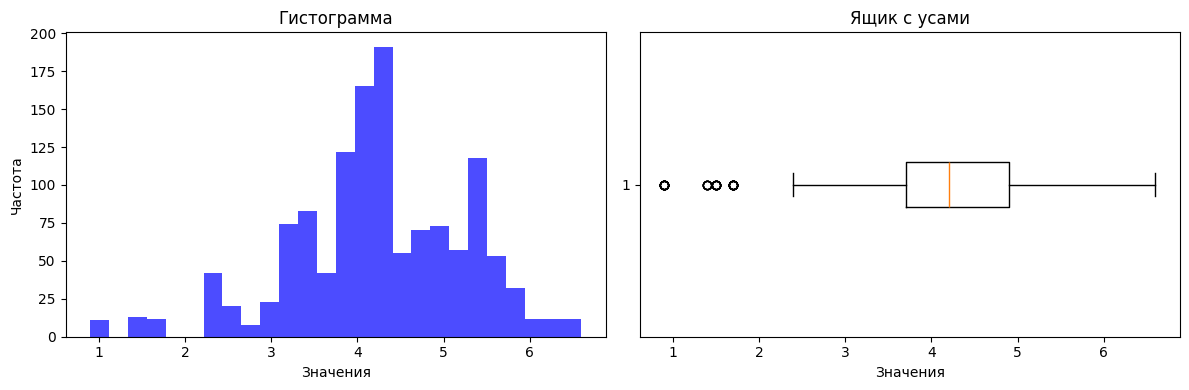

--------------------------------------------------
Столбец "маркет_актив_тек_мес"
Описательная статистика:
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64
--------------------------------------------------


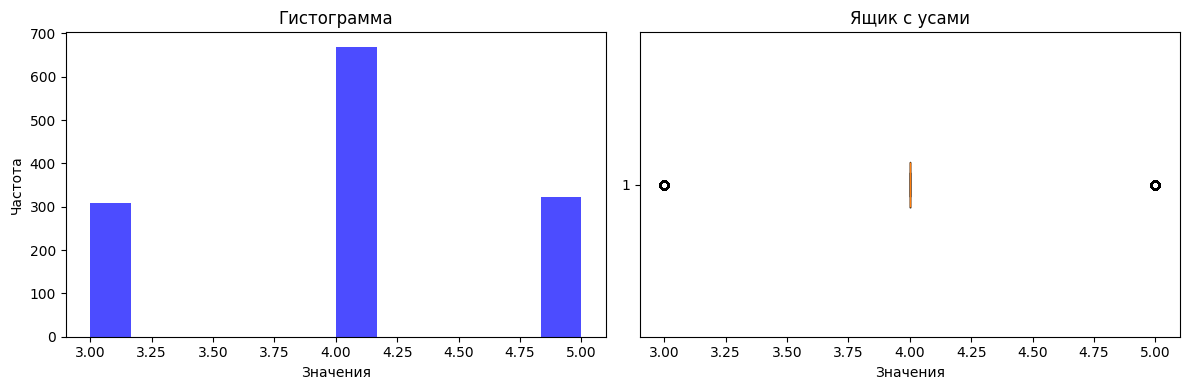

--------------------------------------------------
Столбец "длительность"
Описательная статистика:
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64
--------------------------------------------------


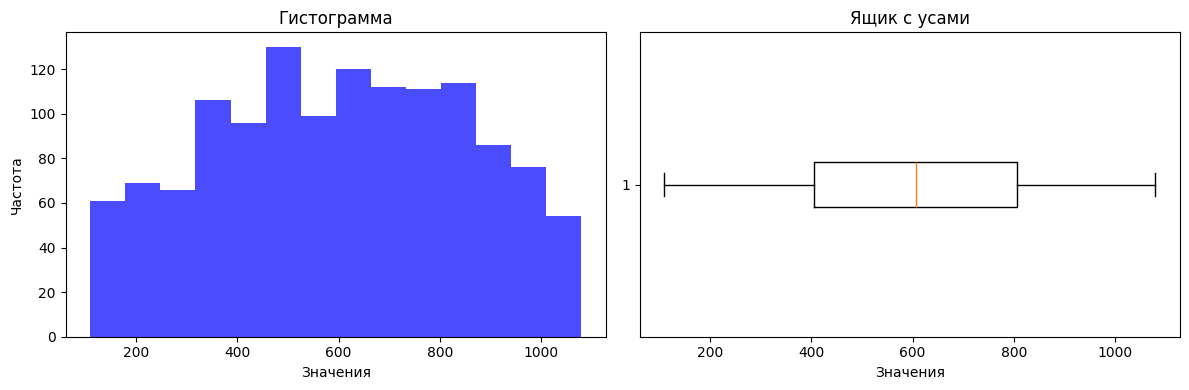

--------------------------------------------------
Столбец "акционные_покупки"
Описательная статистика:
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64
--------------------------------------------------


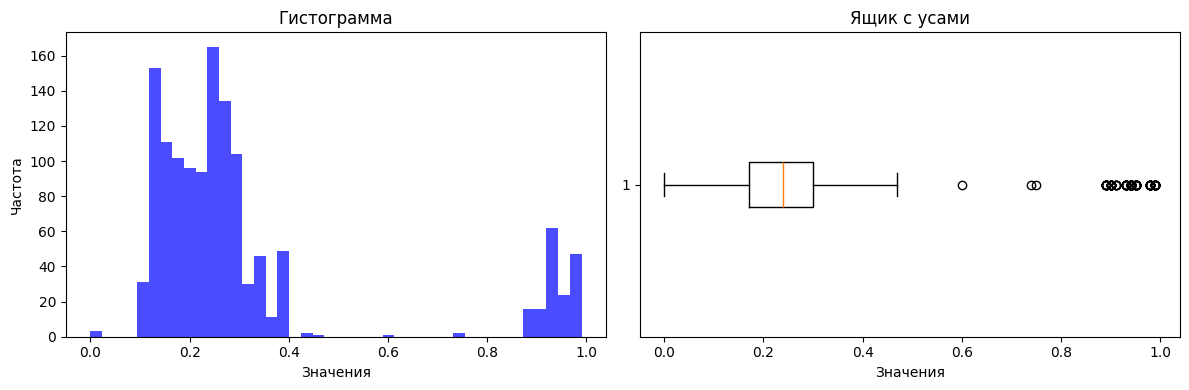

--------------------------------------------------
Столбец "средний_просмотр_категорий_за_визит"
Описательная статистика:
count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64
--------------------------------------------------


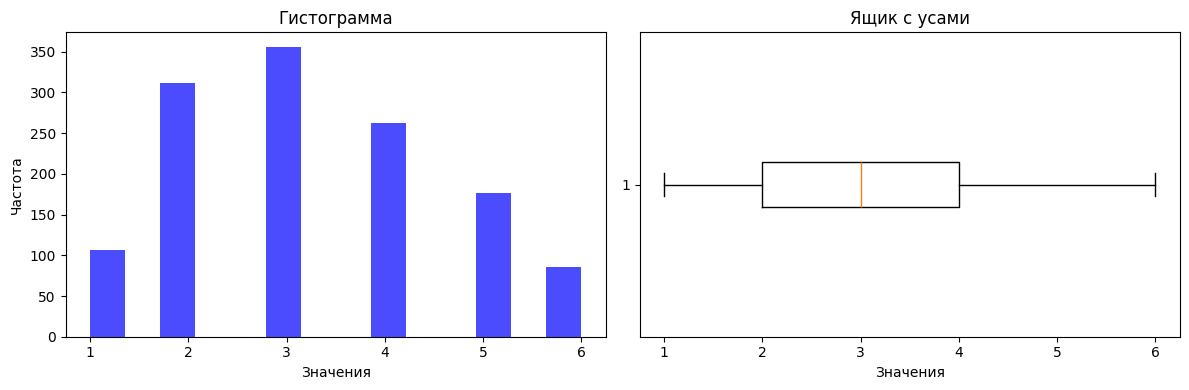

--------------------------------------------------
Столбец "неоплаченные_продукты_штук_квартал"
Описательная статистика:
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64
--------------------------------------------------


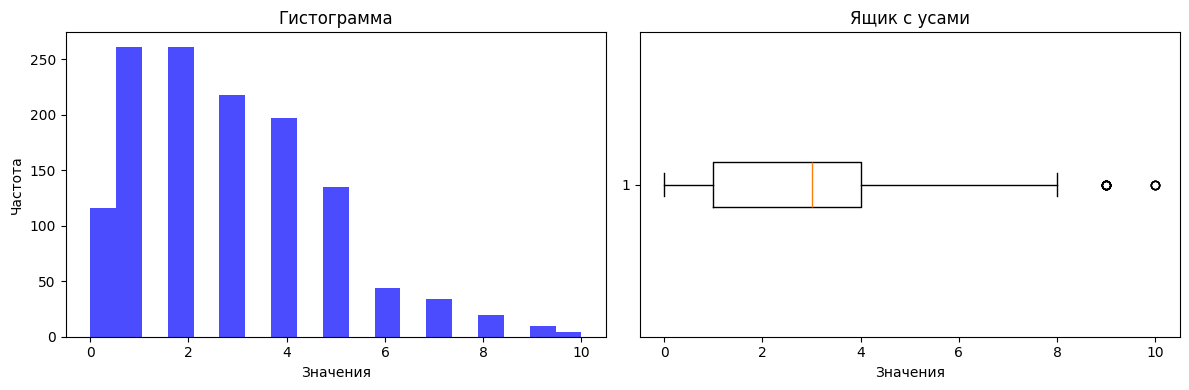

--------------------------------------------------
Столбец "ошибка_сервиса"
Описательная статистика:
count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64
--------------------------------------------------


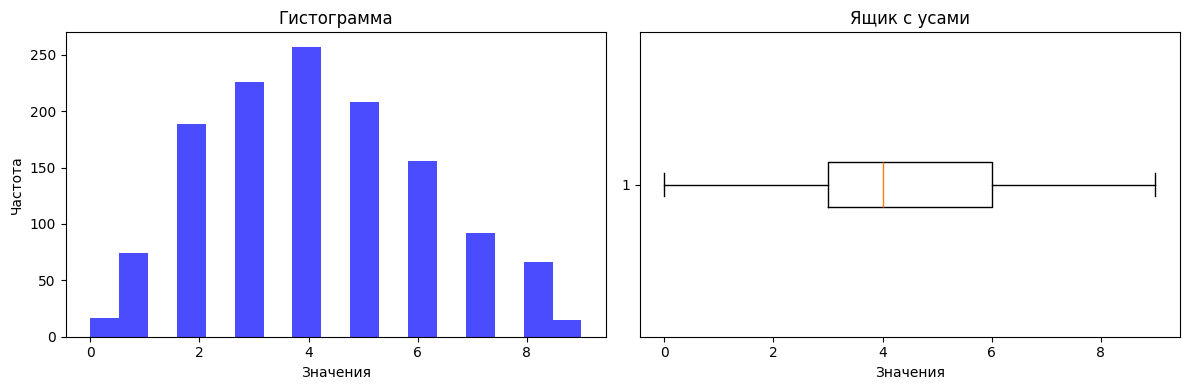

--------------------------------------------------
Столбец "страниц_за_визит"
Описательная статистика:
count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64
--------------------------------------------------


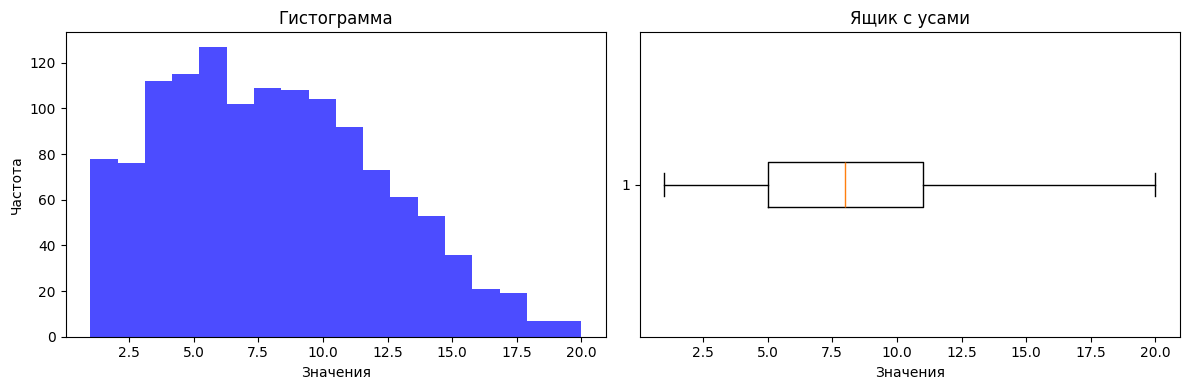

--------------------------------------------------


In [28]:
df_market_file_num = df_market_file.select_dtypes(include='number').drop(['id'], axis=1)

print('Исследовательский анализ числовых данных df_market_file\n')
for col in df_market_file_num.columns:
    print(f'Столбец "{col}"')
    
    # Описательная статистика
    print("Описательная статистика:")
    print(df_market_file_num[col].describe())
    print('-' * 50)
    
    # Построение графиков
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Гистограмма
    axs[0].hist(df_market_file_num[col].dropna(), bins='auto', color='blue', alpha=0.7)
    axs[0].set_title('Гистограмма')
    axs[0].set_xlabel('Значения')
    axs[0].set_ylabel('Частота')
    
    # Ящик с усами
    axs[1].boxplot(df_market_file_num[col].dropna(), vert=False)
    axs[1].set_title('Ящик с усами')
    axs[1].set_xlabel('Значения')
    
    plt.tight_layout()
    plt.show()
    print('-' * 50)

- Теперь категориальные

Исследовательский анализ категориальных данных df_market_file

Столбец "покупательская_активность"
Уникальные значения:
покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Количество уникальных значений: 2


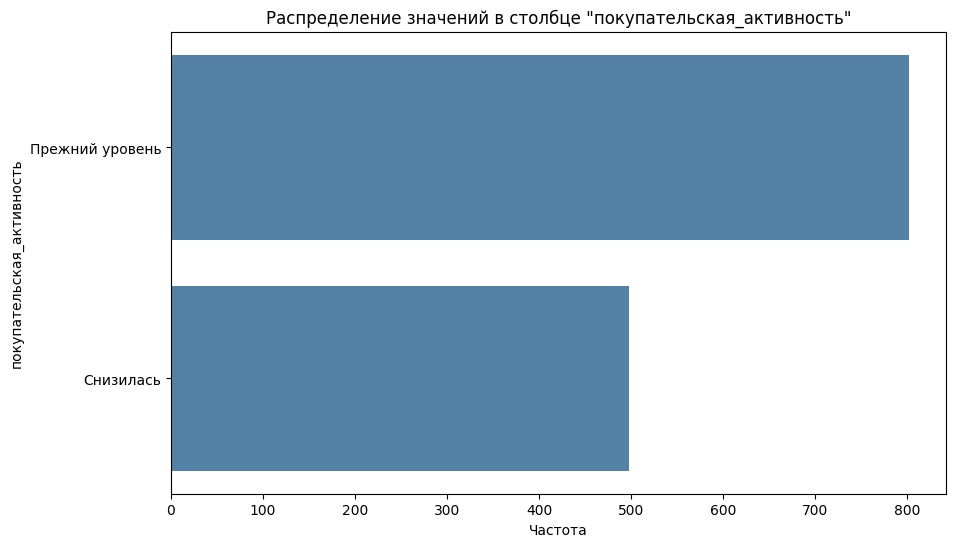

--------------------------------------------------
Столбец "тип_сервиса"
Уникальные значения:
тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

Количество уникальных значений: 2


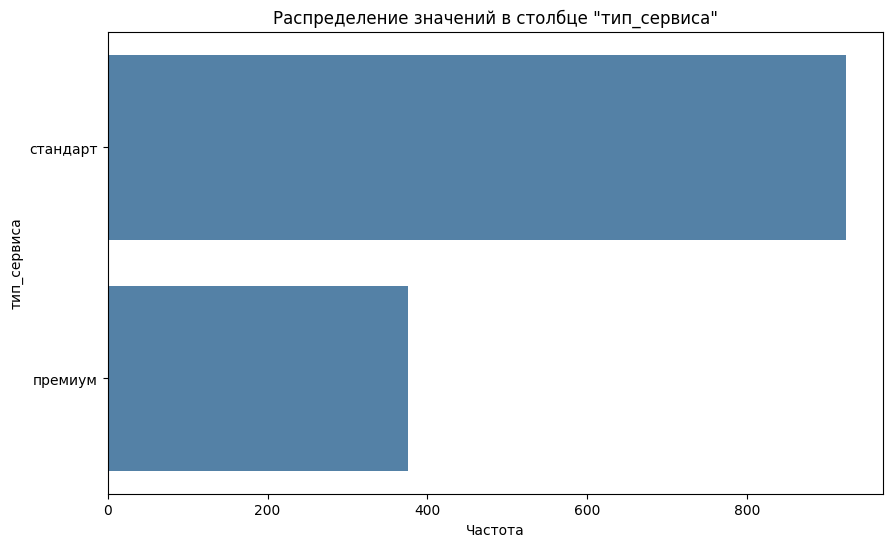

--------------------------------------------------
Столбец "разрешить_сообщать"
Уникальные значения:
разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

Количество уникальных значений: 2


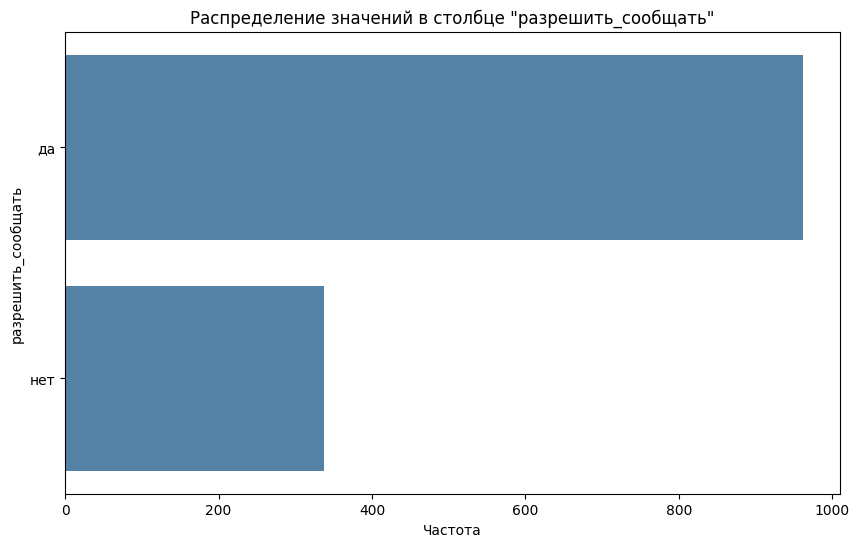

--------------------------------------------------
Столбец "популярная_категория"
Уникальные значения:
популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

Количество уникальных значений: 6


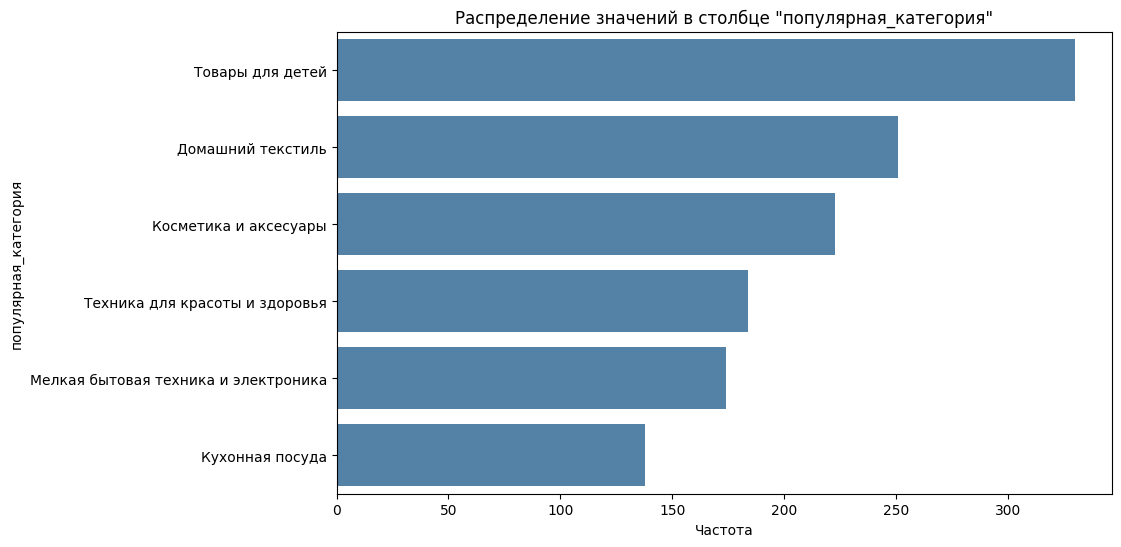

--------------------------------------------------


In [30]:
df_market_file_cat = df_market_file.select_dtypes(exclude='number')

print("Исследовательский анализ категориальных данных df_market_file\n")

# Анализируем каждый категориальный столбец
for col in df_market_file_cat.columns:
    print(f'Столбец "{col}"')
    print("Уникальные значения:")
    print(df_market_file_cat[col].value_counts())
    print("\nКоличество уникальных значений:", df_market_file_cat[col].nunique())
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.countplot(
        y=col, 
        data=df_market_file, 
        order=df_market_file[col].value_counts().index,
        color="steelblue"  # Указываем цвет для графиков
    )
    plt.title(f'Распределение значений в столбце "{col}"')
    plt.xlabel("Частота")
    plt.ylabel(col)
    plt.show()
    print("-" * 50)

- Числовые признаки:

Признак "маркет_актив_6_мес" варьируется от 0.9 до 6.6, с медианным значением 4.2. Распределение имеет небольшой разброс.
Признак "маркет_актив_тек_мес" имеет среднее значение 4.01 и небольшую стандартную ошибку (0.69), что указывает на низкий уровень вариативности.
"Длительность" имеет широкий разброс значений (от 110 до 1079 минут), что свидетельствует о разной продолжительности взаимодействия пользователей.
Признак "акционные_покупки" варьируется от 0 до 0.99, с медианным значением 0.24, что может указывать на то, что акционные покупки не являются массовым явлением.
Признак "средний_просмотр_категорий_за_визит" показывает, что в среднем пользователи просматривают 3 категории, при этом максимум достигает 6 категорий.
Признак "неоплаченные_продукты_штук_квартал" варьируется от 0 до 10, с медианным значением 3, что может свидетельствовать о проблемах с завершением покупки.
Признак "ошибка_сервиса" имеет среднее значение 4.18 и широкий диапазон (от 0 до 9), что может быть индикатором уровня качества сервиса.
"Страниц_за_визит" варьируется от 1 до 20, с медианным значением 8, что указывает на разную глубину взаимодействия пользователей с платформой.
- Категориальные признаки:

Признак "покупательская_активность" показывает, что у 61.7% пользователей активность осталась на прежнем уровне, в то время как у 38.3% она снизилась.
Признак "тип_сервиса" делится на "стандарт" (71%) и "премиум" (29%), что может говорить о значительном перекосе в использовании стандартного типа сервиса.
Признак "разрешить_сообщать": большинство пользователей (74%) согласны на получение уведомлений, что может быть полезным для маркетинговых стратегий.
"Популярная_категория" показывает, что наиболее востребованы товары для детей (25.4%), в то время как менее популярна кухонная посуда (10.6%).

- далее Так же посмотрим и на остальные датафреймы

Исследовательский анализ числовых данных df_market_money

Описательная статистика для столбца 'выручка':
count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64
--------------------------------------------------


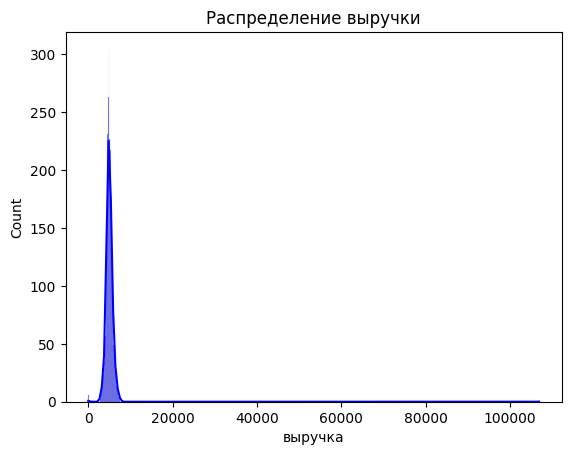

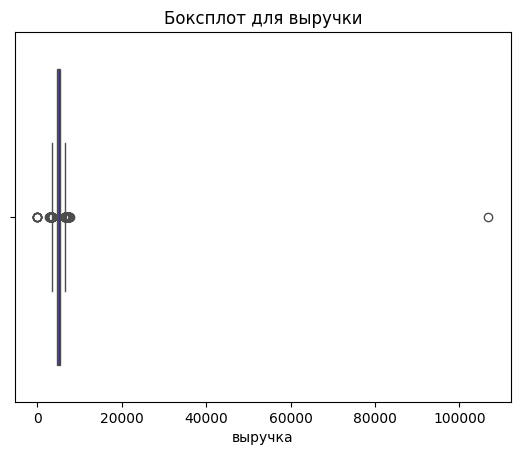

Исследовательский анализ категориальных данных df_market_money

Уникальные значения для столбца 'период':
период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64
--------------------------------------------------


/var/folders/nn/zl0wkc3j0t96pmr4m7cfjd9r0000gn/T/ipykernel_38522/2044463274.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='период', data=df_market_money, palette='viridis')


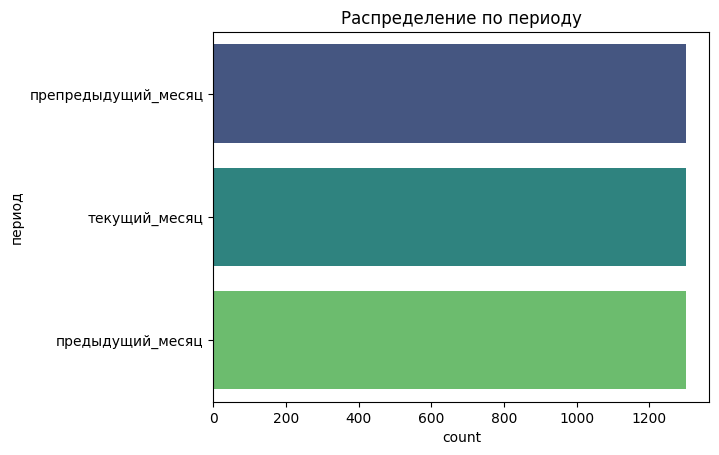

In [33]:
print("Исследовательский анализ числовых данных df_market_money\n")

# Описательная статистика для числовых данных
print("Описательная статистика для столбца 'выручка':")
print(df_market_money['выручка'].describe())
print("-" * 50)

# Гистограмма и боксплот для 'выручка'
sns.histplot(df_market_money['выручка'], kde=True, color='blue')
plt.title('Распределение выручки')
plt.show()

sns.boxplot(x=df_market_money['выручка'], color='blue')
plt.title('Боксплот для выручки')
plt.show()

# Анализ категориальных данных
print("Исследовательский анализ категориальных данных df_market_money\n")

# Уникальные значения для столбца 'период'
print("Уникальные значения для столбца 'период':")
print(df_market_money['период'].value_counts())
print("-" * 50)

# График распределения по категориям 'период'
sns.countplot(y='период', data=df_market_money, palette='viridis')
plt.title('Распределение по периоду')

# Если нужно скрыть легенду:
plt.legend([], [], frameon=False)

plt.show()

Исследовательский анализ числовых данных df_market_money

Описательная статистика для столбца 'выручка':
count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64
--------------------------------------------------


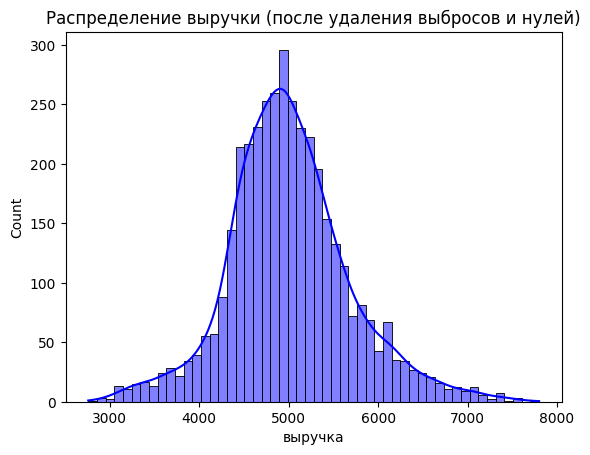

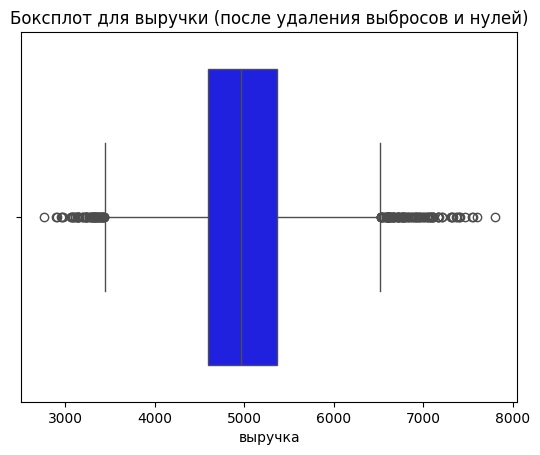

Исследовательский анализ категориальных данных df_market_money

Уникальные значения для столбца 'период':
период
текущий_месяц          1299
препредыдущий_месяц    1297
предыдущий_месяц       1297
Name: count, dtype: int64
--------------------------------------------------


/var/folders/nn/zl0wkc3j0t96pmr4m7cfjd9r0000gn/T/ipykernel_38522/4180024116.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='период', data=df_market_money, palette='viridis')


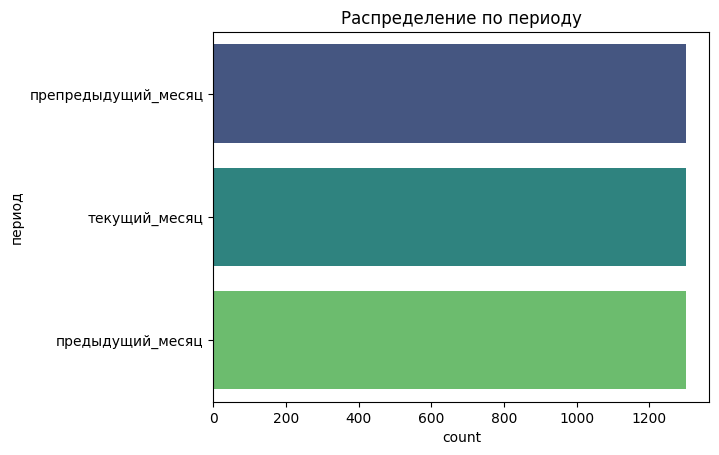

In [34]:
df_market_money_filtered = df_market_money[(df_market_money['выручка'] <= 100000) & (df_market_money['выручка'] > 0)]

# Исследовательский анализ числовых данных df_market_money
print("Исследовательский анализ числовых данных df_market_money\n")

# Описательная статистика для числовых данных после удаления выбросов и нулей
print("Описательная статистика для столбца 'выручка':")
print(df_market_money_filtered['выручка'].describe())
print("-" * 50)

# Гистограмма и боксплот для 'выручка'
sns.histplot(df_market_money_filtered['выручка'], kde=True, color='blue')
plt.title('Распределение выручки (после удаления выбросов и нулей)')
plt.show()

sns.boxplot(x=df_market_money_filtered['выручка'], color='blue')
plt.title('Боксплот для выручки (после удаления выбросов и нулей)')
plt.show()

# Анализ категориальных данных
print("Исследовательский анализ категориальных данных df_market_money\n")

# Уникальные значения для столбца 'период'
print("Уникальные значения для столбца 'период':")
print(df_market_money_filtered['период'].value_counts())
print("-" * 50)

# График распределения по категориям 'период'
sns.countplot(y='период', data=df_market_money, palette='viridis')
plt.title('Распределение по периоду')
plt.legend([], [], frameon=False)  # Скрываем легенду, если она не нужна
plt.show()


- Нашли аномальные значения, без них графики выглядят прятнее) но это может быть просто богатый человек.


Количество: 3900 значений.
Среднее значение: 5025.70.
Стандартное отклонение: 1777.70, что указывает на значительную изменчивость данных.
Минимум: 0 (наличие нулевых значений, присутствует).
Максимум: 106862.2 (выбросы).
После обработки:
Количество: 3893 значений (удалено 7 записей с выбросами и нулями).
Среднее значение: 5007.28 (незначительное снижение).
Стандартное отклонение: 679.72, что указывает на меньшее рассеивание данных после удаления выбросов.
Минимум: 2758.7, больше нулевых значений нет.
Максимум: 7799.4, выбросы устранены.
Категориальные данные
До обработки:
Равномерное распределение: 1300 записей для каждого периода.
После обработки:
Небольшие изменения в распределении: текущее значение осталось почти тем же, но для "предыдущего" и "препредыдущего" месяцев немного снизилось из-за удаленных записей.
Итог
Обработка данных позволила улучшить качество числовых данных, удалив нулевые значения и выбросы, что уменьшило разброс (std) и сделало распределение более компактным. Категориальные данные остались в основном неизменными, что говорит о том, что удаление выбросов равномерно повлияло на все категории.

Исследовательский анализ числовых данных df_market_time

Описательная статистика для столбца 'минут':
count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64
--------------------------------------------------


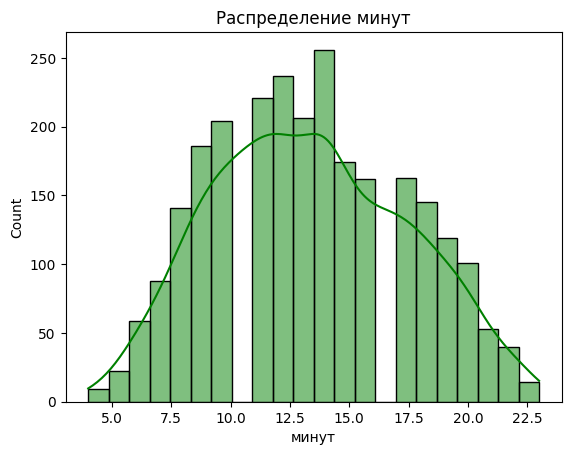

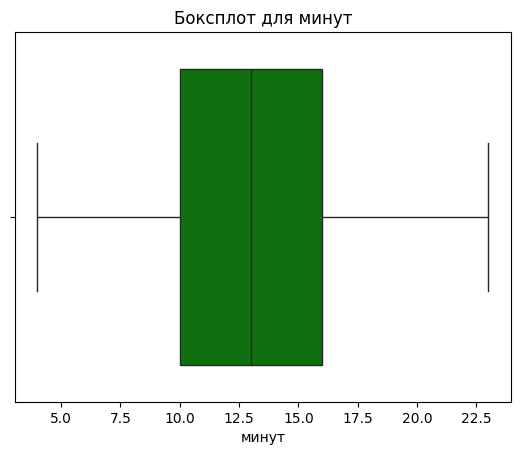

Границы выбросов: ниже 1.0 и выше 25.0
Количество выбросов: 0
--------------------------------------------------
Исследовательский анализ категориальных данных df_market_time

Уникальные значения для столбца 'период':
период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64
--------------------------------------------------


/var/folders/nn/zl0wkc3j0t96pmr4m7cfjd9r0000gn/T/ipykernel_38522/1033251174.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='период', data=df_market_time, palette='viridis')


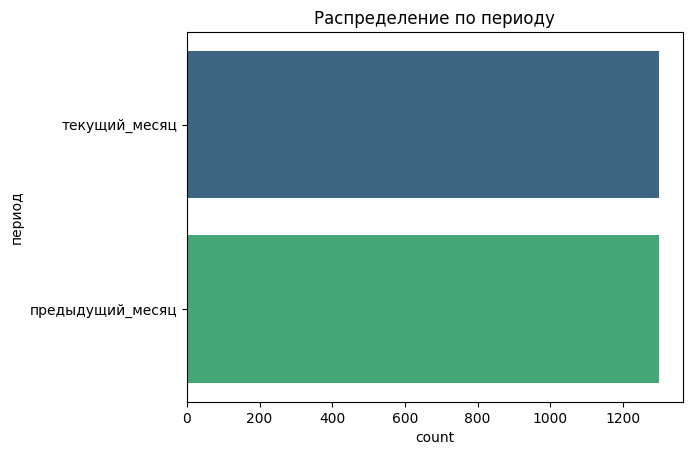

In [36]:
print("Исследовательский анализ числовых данных df_market_time\n")

# Описательная статистика для числовых данных
print("Описательная статистика для столбца 'минут':")
print(df_market_time['минут'].describe())
print("-" * 50)

# Построение гистограммы и боксплота для анализа распределения
sns.histplot(df_market_time['минут'], kde=True, color='green')
plt.title('Распределение минут')
plt.show()

sns.boxplot(x=df_market_time['минут'], color='green')
plt.title('Боксплот для минут')
plt.show()

# Проверка на выбросы
q1 = df_market_time['минут'].quantile(0.25)
q3 = df_market_time['минут'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Границы выбросов: ниже {lower_bound} и выше {upper_bound}")
outliers = df_market_time[(df_market_time['минут'] < lower_bound) | (df_market_time['минут'] > upper_bound)]
print(f"Количество выбросов: {len(outliers)}")
print("-" * 50)

# Исследовательский анализ категориальных данных
print("Исследовательский анализ категориальных данных df_market_time\n")

# Уникальные значения для столбца 'период'
print("Уникальные значения для столбца 'период':")
print(df_market_time['период'].value_counts())
print("-" * 50)

# Построение графика распределения по категориям
sns.countplot(y='период', data=df_market_time, palette='viridis')
plt.title('Распределение по периоду')
plt.show()


- Вроде все хорошо

Исследовательский анализ числовых данных df_money

Описательная статистика для числовых столбцов:
                  id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000
--------------------------------------------------
Графики для столбца 'прибыль':


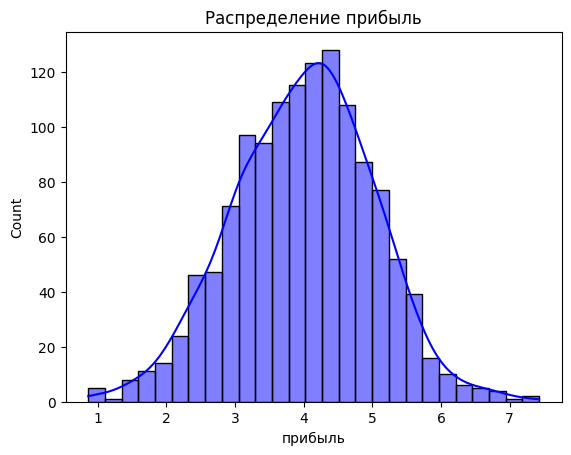

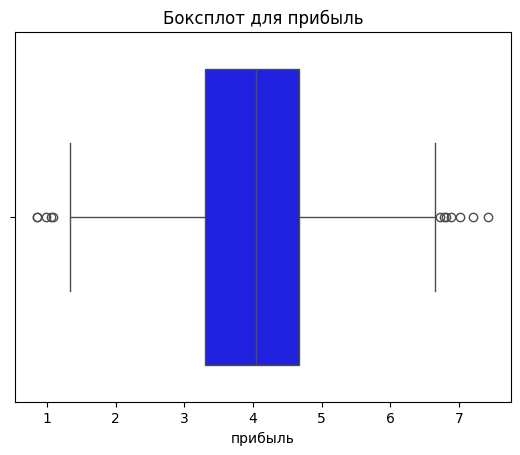

--------------------------------------------------


In [38]:
print("Исследовательский анализ числовых данных df_money\n")

# Описательная статистика для числовых столбцов
numerical_cols = df_money.select_dtypes(include=['number']).columns
print("Описательная статистика для числовых столбцов:")
print(df_money[numerical_cols].describe())
print("-" * 50)

# Исключение столбца id из визуализации
numerical_cols = [col for col in numerical_cols if col != 'id']

# Построение гистограмм и боксплотов
for col in numerical_cols:
    print(f"Графики для столбца '{col}':")
    sns.histplot(df_money[col], kde=True, color='blue')
    plt.title(f'Распределение {col}')
    plt.show()

    sns.boxplot(x=df_money[col], color='blue')
    plt.title(f'Боксплот для {col}')
    plt.show()
    print("-" * 50)

In [39]:
# Определяем пользователей с нулевой выручкой в каком-либо периоде
no_active_id = df_market_money.query('выручка == 0')['id'].unique()
print(f'id пользователей с непостоянной покупательской активностью: {no_active_id}')

# Фильтруем пользователей с постоянной активностью
active_users_three_months = df_market_money[~df_market_money['id'].isin(no_active_id)]

# Фильтруем пользователей с непостоянной активностью
no_active_users_three_months = df_market_money[df_market_money['id'].isin(no_active_id)]

# Вывод результатов
print('Всего строк df_market_money:', len(df_market_money))
print('Строк после отсеивания пользователей с непостоянной активностью:', len(active_users_three_months))

print('\nПользователи с непостоянной активностью:')
print('Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев:', active_users_three_months['id'].nunique())
active_users_three_months

id пользователей с непостоянной покупательской активностью: [215348 215357 215359]
Всего строк df_market_money: 3900
Строк после отсеивания пользователей с непостоянной активностью: 3891

Пользователи с непостоянной активностью:
Количество пользователей с постоянной покупательской активностью в течение последних трёх месяцев: 1297


,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


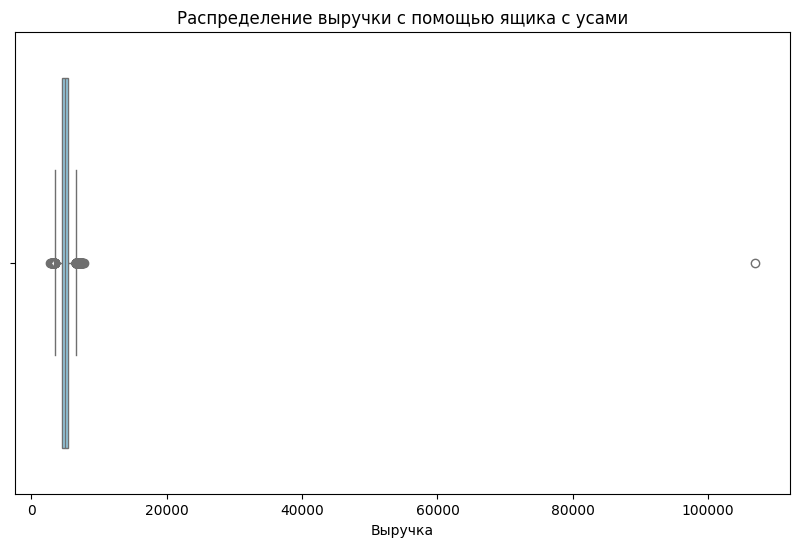

In [40]:
df_market_money.describe()

# Построение ящика с усами
plt.figure(figsize=(10, 6))
sns.boxplot(data=active_users_three_months, x='выручка', color='skyblue')
plt.title('Распределение выручки с помощью ящика с усами')
plt.xlabel('Выручка')
plt.show()

In [41]:
# Находим id, где хотя бы одна выручка больше 100000
high_revenue_ids = active_users_three_months.query('выручка > 100000')['id'].unique()

# Удаляем строки с этими id
active_users_three_months = active_users_three_months[~active_users_three_months['id'].isin(high_revenue_ids)]

# Проверяем результат
print('Количество строк после удаления id с выручкой > 100000:', len(active_users_three_months))
print(active_users_three_months.describe())


Количество строк после удаления id с выручкой > 100000: 3888
                  id      выручка
count    3888.000000  3888.000000
mean   215999.464506  5007.255658
std       374.231545   679.193461
min    215349.000000  2758.700000
25%    215675.750000  4591.950000
50%    215999.500000  4959.000000
75%    216323.250000  5363.000000
max    216647.000000  7799.400000


In [42]:
active_users_three_months.info()
active_users_three_months['id'].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 3888 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3888 non-null   int64  
 1   период   3888 non-null   object 
 2   выручка  3888 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.5+ KB


1296

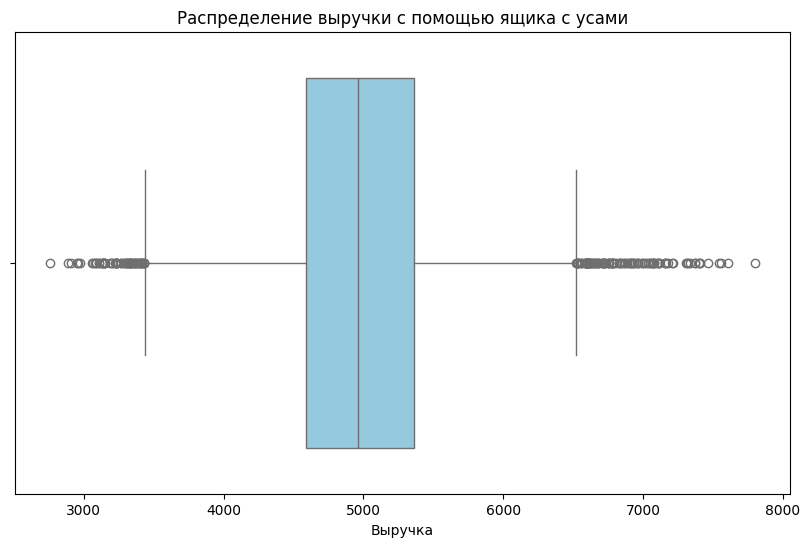

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=active_users_three_months, x='выручка', color='skyblue')
plt.title('Распределение выручки с помощью ящика с усами')
plt.xlabel('Выручка')
plt.show()

In [44]:
active_users_three_months.shape[0]

3888

 ### Промежуточный вывод

-

Изучены распределения числовых признаков, выявлены нормальные и мультимодальные распределения.
Основные показатели (среднее, медиана) для ключевых столбцов:
маркет_актив_6 мес: 4.25 (среднее), 4.20 (медиана)
длительность: 601.90 (среднее), 606.00 (медиана)
акционные_покупки: 0.32 (среднее), 0.24 (медиана)
Выбросы в столбцах не были найдены, кроме выручки в df_market_money (выброс 106862.2).
Категориальные признаки:

В df_market_file основное распределение: 61.69% пользователей с прежним уровнем активности, 71.08% с типом сервиса стандарт.
В df_market_file популярные категории товаров: Товары для детей (25.38%), Домашний текстиль (19.31%), Косметика и аксессуары (17.15%).
В df_market_money данные распределены поровну между текущим и предыдущими месяцами.
Данные пользователей:

Выбраны активные пользователи, совершающие покупки ежемесячно, их количество — 1297. после чистки выбросов стало 1296


## Шаг 4. Объединение таблиц

In [48]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [49]:
active_users_three_months.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3888 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3888 non-null   int64  
 1   период   3888 non-null   object 
 2   выручка  3888 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.5+ KB


In [50]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [51]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [52]:
# Создание датафреймов для 'выручка' и 'минут' по каждому периоду
df_market_money_grouped = (active_users_three_months
                           .pivot_table(index='id', columns='период', values='выручка')
                           .rename(columns={'текущий_месяц': 'выручка_текущий_месяц',
                                            'предыдущий_месяц': 'выручка_предыдущий_месяц',
                                            'препредыдущий_месяц': 'выручка_препредыдущий_месяц'}))

df_market_time_grouped = (df_market_time
                          .pivot_table(index='id', columns='период', values='минут')
                          .rename(columns={'текущий_месяц': 'минут_текущий_месяц',
                                           'предыдущий_месяц': 'минут_предыдущий_месяц'}))

# Объединение всех датафреймов
df_merged_final = (df_market_file
                   .merge(df_market_money_grouped, on='id')
                   .merge(df_market_time_grouped, on='id')
                   .reset_index(drop=True))

# Проверка результата
print(df_merged_final.shape)
df_merged_final.head()


(1296, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


In [53]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Таблицы объединены.

## Шаг 5. Корреляционный анализ


interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


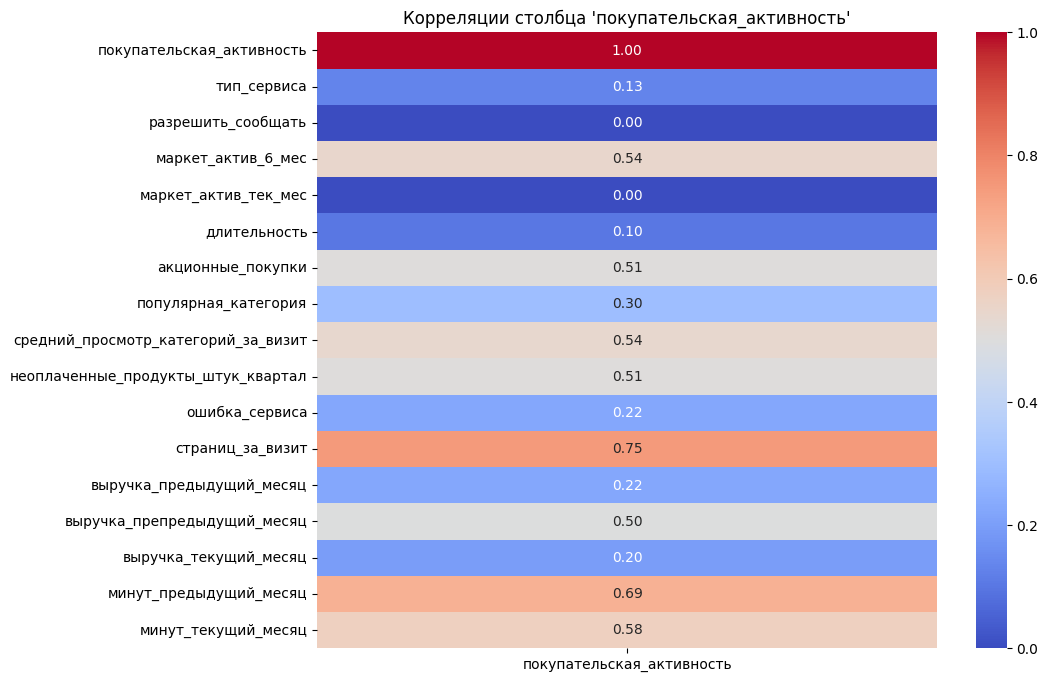

In [57]:
# Удаляем столбец 'id' перед расчетом корреляции
phik_matrix = df_merged_final.drop('id', axis=1).phik_matrix()

# Визуализация корреляции для столбца 'покупательская_активность'
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix[["покупательская_активность"]], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляции столбца 'покупательская_активность'")
plt.show()


Столбцы Маркет_актив_6_мес, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал и Страниц_за_визит умеренно коррелируют с покупательской активностью, указывая на их влияние на поведение клиентов. Другие признаки имеют слабое или нулевое влияние на покупательскую активность и могут быть менее значимыми для прогнозирования.

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


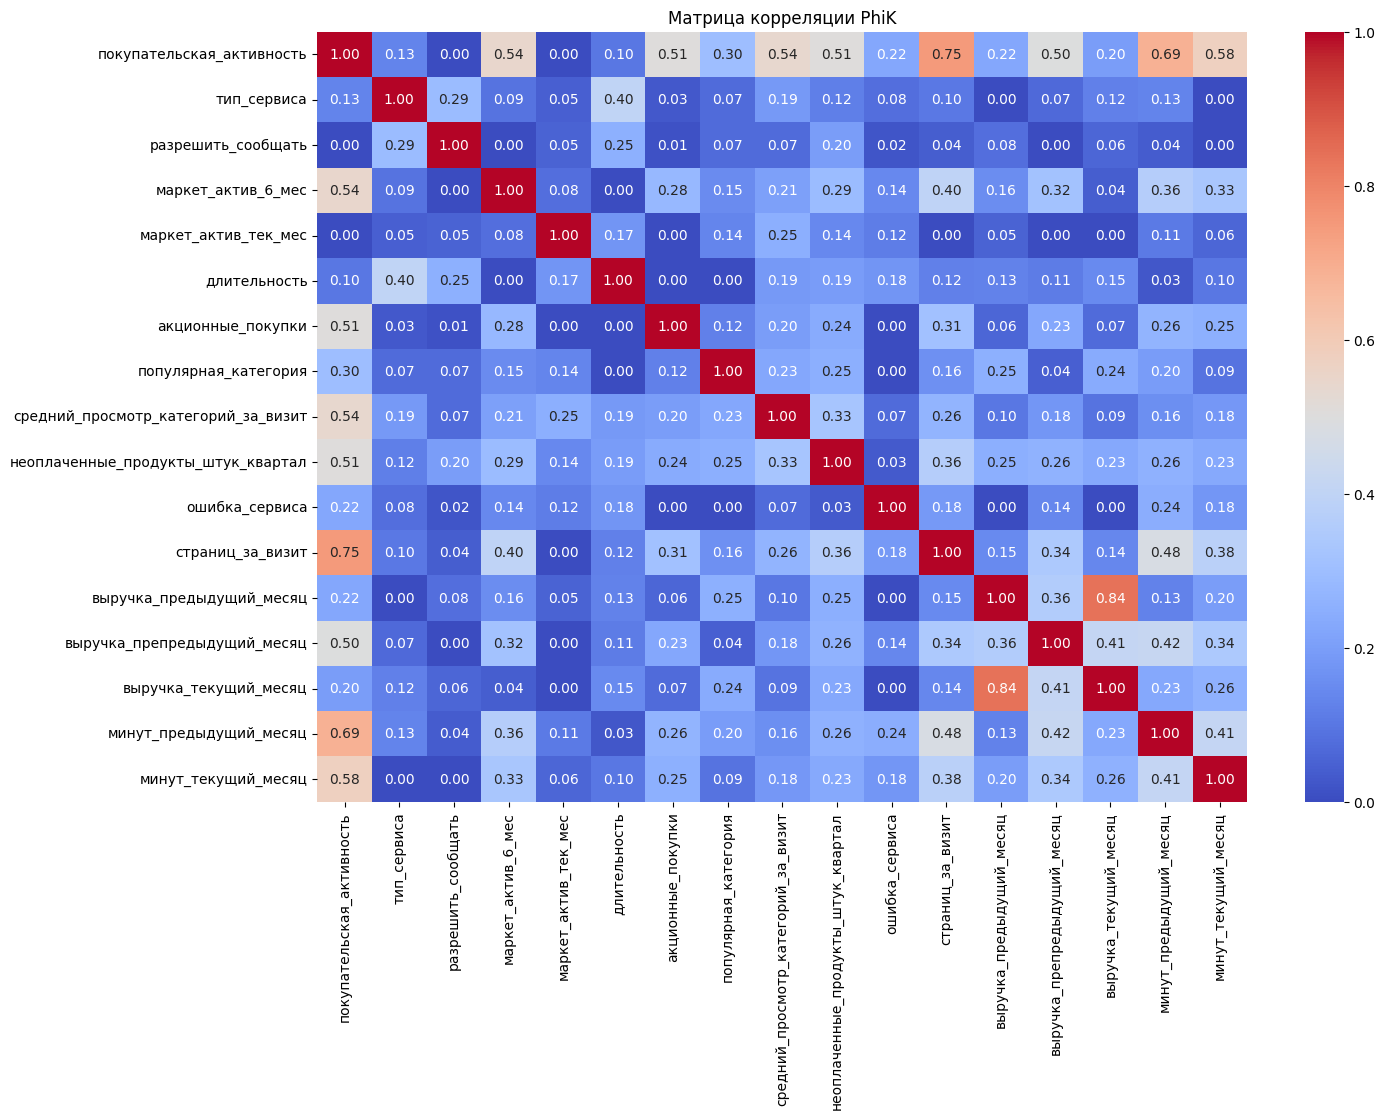

In [59]:
# Удаление столбца 'id'
data_without_id = df_merged_final.drop('id', axis=1)

# Вычисление матрицы корреляции Phi_K для данных без 'id'
phik_matrix = data_without_id.phik_matrix()

# Визуализация матрицы корреляции Phi_K
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляции PhiK")
plt.show()

#### Вспомнил Спринт 10/33 Тема 8/11 Урок 2/7, там написано...
- Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки.
- У нас таких не наблюдается

Признаки, такие как Страниц за визит, минут предыдущ и текущий месяц, имеют сильную положительную корреляцию с покупательской активностью, что делает их хорошими предикторами. Маркет_актив6мес, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал и умеренно коррелируют с покупательской активностью, указывая на их влияние на поведение клиентов. Другие признаки имеют слабое или нулевое влияние на покупательскую активность и могут быть менее значимыми для прогнозирования.

###### Промежуточный вывод V2

Признаки, такие как Страниц за визит имеют очень сильную корреляцию с покупательской активностью (0.75), Минут предыдущий и текущий месяц, Маркет_актив6мес,  Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал имеют сильную связь с покупательской активностью (0.51–0.69), что делает их хорошими кандидатами для предикторов. Признаки популярная категория,демонстрируют умеренную или слабою корреляцию (0.3).

Остальные признаки с слабой связью (0.1–0.3) или её отсутствием (0) имеют менее значимое влияние на покупательскую активность и могут быть менее важны для прогнозирования.

## Шаг 6. Использование пайплайнов

In [64]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

/var/folders/nn/zl0wkc3j0t96pmr4m7cfjd9r0000gn/T/ipykernel_38522/2009912619.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_merged_final['покупательская_активность'].replace({'Прежний уровень': 0, 'Снизилась': 1})


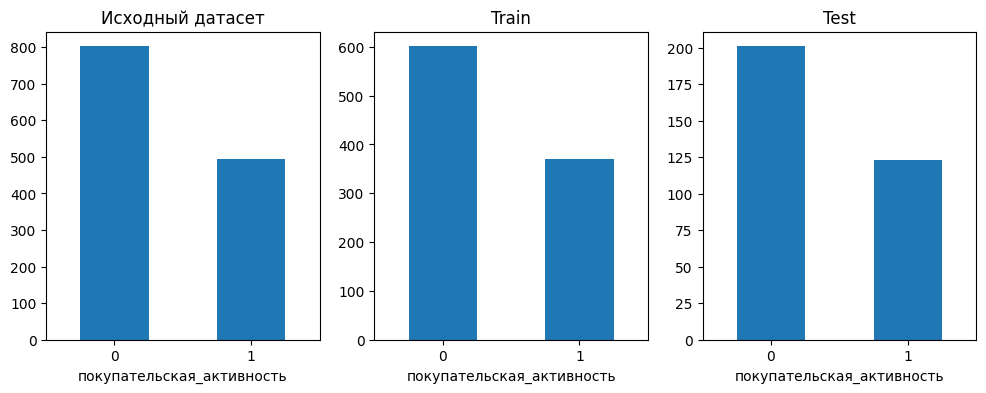

In [65]:
# Устанавливаем RANDOM_STATE и TEST_SIZE
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Преобразуем целевой признак в числовые значения, избегая предупреждения
y = df_merged_final['покупательская_активность'].replace({'Прежний уровень': 0, 'Снизилась': 1})

# Явно преобразуем тип данных
y = pd.to_numeric(y, errors='coerce')

# Выделяем в отдельные переменные целевой признак и входные признаки
X = df_merged_final.drop(columns=['покупательская_активность', 'id'])

# Разбиваем данные на выборки с учётом стратификации по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE, 
    stratify=y
) 

# Визуализируем баланс целевого признака в выборках
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Для исходного набора данных
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")

# Для обучающей выборки
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")

# Для тестовой выборки
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")

plt.show()

In [66]:
%%time

# создаём списки с названиями признаков для кодирования и масштабирования/стандартизации
# признаки для кодирования OneHotEncoder
ohe_columns = ['популярная_категория']

# признаки для кодирования OrdinalEncoder
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

# признаки для масштабирования/стандартизации
num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 
               'страниц_за_визит', 
               'выручка_текущий_месяц', 
               'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 
               'минут_текущий_месяц', 
               'минут_предыдущий_месяц']

# добавляем OHE-кодирование в пайплайн
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))])

# добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
    categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']
    ], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))
                    ]
                   )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн для обучения модели
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

# Обновляем param_grid, добавляя параметры для SVC
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 80),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],  # Можно настроить диапазон для гиперпараметра C
        'models__kernel': ['linear', 'rbf', 'poly'],  # Подбираем ядро для SVC
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    }
]

# Переобучаем модель с использованием RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=['roc_auc', 'accuracy', 'recall'],
    refit='roc_auc',
    n_iter=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# обучаем лучшую модель на тренировочных данных
randomized_search.fit(X_train, y_train)

# выводим на экран лучшую модель, её параметры и метрику ROC-AUC на тренировочной выборке
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(line_1)
print(f'Параметры лучшей модели:\n{randomized_search.best_params_}')
print(line_1)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 3))
print(line_1)

# проверяем работу модели на тестовой выборке
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred_proba), 3)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['да',
                    

In [67]:
# Создаем DataFrame с нужными столбцами
results_df = pd.DataFrame(randomized_search.cv_results_)[
    ['mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc', 'params']
]

# Сортируем по рангу тестового результата
results_df = results_df.sort_values('rank_test_roc_auc')

# Выводим результаты на экран
results_df


,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,params
16,0.896394,0.018201,1,"{'preprocessor__num': RobustScaler(), 'models_..."
13,0.896394,0.018223,1,"{'preprocessor__num': StandardScaler(), 'model..."
5,0.896371,0.018199,3,"{'preprocessor__num': RobustScaler(), 'models_..."
11,0.827810,0.024629,4,"{'preprocessor__num': MinMaxScaler(), 'models_..."
19,0.821745,0.029348,5,"{'preprocessor__num': StandardScaler(), 'model..."
1,0.818333,0.023740,6,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,0.817849,0.043598,7,"{'preprocessor__num': StandardScaler(), 'model..."
10,0.815063,0.032651,8,"{'preprocessor__num': StandardScaler(), 'model..."
18,0.812347,0.019204,9,"{'preprocessor__num': MinMaxScaler(), 'models_..."
0,0.809531,0.022744,10,"{'preprocessor__num': RobustScaler(), 'models_..."


####  Промежуточный вывод
- Мы использовали RandomizedSearchCV для подбора гиперпараметров и поиска лучшей модели. Применили метрику roc_auc, которая является хорошей метрикой для оценки классификационных моделей, особенно для несбалансированных классов.

Метрика ROC-AUC: Мы выбрали метрику roc_auc, что является отличным выбором для данной задачи, так как она оценивает качество классификации на разных уровнях порогов и не чувствительна к дисбалансу классов.
Лучшие гиперпараметры и модель:  Мы нашли лучшую модель (LogisticRegression(C=68, penalty='l1', random_state=42,
solver='liblinear'), а также выбрали RobustScaler для числовых признаков, что оптимизирует работу модели с выбросами.

In [69]:
# кодируем категориальные признаки с помощью OneHotEncoder()
#ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')
#X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
#X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
#ohe_encoder_col_names = ohe_encoder.get_feature_names_out(ohe_columns)  # Исправлено

# кодируем категориальные признаки с помощью OrdinalEncoder()
#ord_encoder = OrdinalEncoder()
#X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
#X_test_ord = ord_encoder.transform(X_test[ord_columns])
# OrdinalEncoder не имеет метода get_feature_names_out, так что пропустим создание имен колонок

# масштабируем количественные признаки с помощью StandardScaler()
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train[num_columns])
#X_test_scaled = scaler.transform(X_test[num_columns])

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
#X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
#X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

#X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)  # Используем ord_columns для имен
#X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)  # Используем ord_columns для имен

#X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
#X_train_first = pd.concat([X_train_ohe, X_train_ord], axis=1)
#X_train_final = pd.concat([X_train_first, X_train_scaled], axis=1)

#X_test_first = pd.concat([X_test_ohe, X_test_ord], axis=1)
#X_test_final = pd.concat([X_test_first, X_test_scaled], axis=1)

# проверяем размерности выборок
#print('Размерности выборок:')

#shape_data = {'Выборка': ['X_train_final', 'X_test_final', 'y_train', 'y_test'], 
#              'Размер': [X_train_final.shape, X_test_final.shape, y_train.shape, y_test.shape]} 

#display(pd.DataFrame(shape_data))

In [70]:
# объявляем классификатор и обучаем модель
#clf_best = LogisticRegression(C=72, penalty='l1', random_state=42, solver='liblinear')
#clf_best.fit(X_train_final, y_train)
#y_pred = clf_best.predict(X_test_final)

# в отдельную переменную сохраняем предсказания принадлежности к классам для тестовых данных
#clf_best_probas = clf_best.predict_proba(X_test_final)[:,1]

# считаем метрику ROC-AUC для тренировочных и тестовых данных
#print('Метрики Best Model:')
#roc_auc_cv = cross_val_score(clf_best, X_train_final, y_train, scoring='roc_auc').mean()
#print(f'ROC-AUC на тренировочной выборке: {round(roc_auc_cv, 3)}')
#print(f'ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 3)}')

# оценка качества модели по метрике accuracy
#clf_best_acc = accuracy_score(y_test, y_pred)
#print('Accuracy:', round(clf_best_acc, 3))

# выводим F1-меру
#clf_best_f1 = f1_score(y_test, y_pred, pos_label=1)
#print('F1-score:', round(clf_best_f1, 3))

## Шаг 7. Анализ важности признаков

In [72]:
#best_model = randomized_search.best_estimator_
#data_preprocessor = best_model.named_steps['preprocessor']
#X_train_transformed = data_preprocessor.transform(X_train)

#explainer = shap.LinearExplainer(best_model.named_steps['models'], X_train_transformed)
#shap_values = explainer(X_train_transformed)
#shap.plots.beeswarm(shap_values, max_display=10, plot_size=(10,10))

In [73]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
)

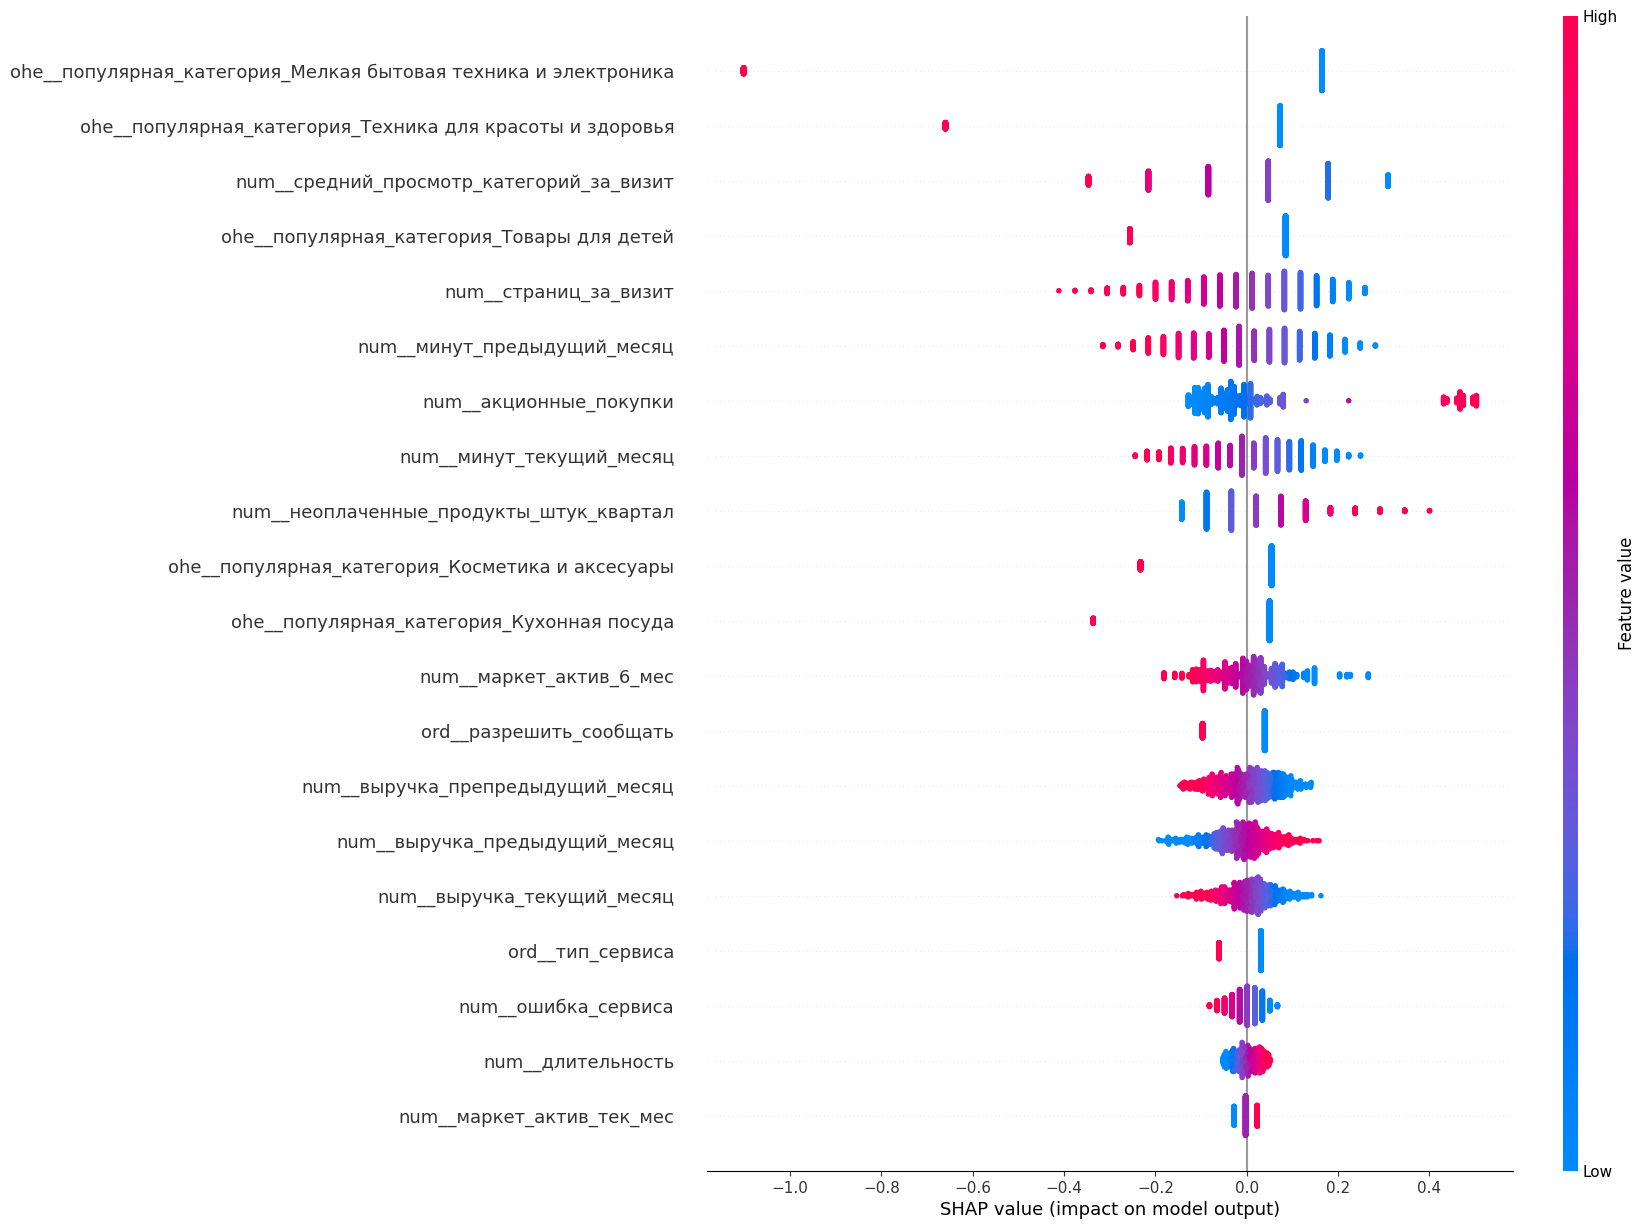

In [74]:
best_model = randomized_search.best_estimator_
explainer = shap.LinearExplainer(best_model.named_steps['models'], X_train_p)
shap_values = explainer(X_train_p)
shap.plots.beeswarm(shap_values, max_display=22, plot_size=(13,15))

In [75]:
#shap.plots.waterfall(shap_values[300])

- Вывод V2
Как видно по диаграмме, имеют значительный вклад в прогнозировании:

страниц_за_визит, 
минут_предыдущий месяц,
минут_текущий месяц, 
маркет_актив_6_мес,
неоплаченные_продукты_штук_квартал
средний_просмотр_категорий_за_визит, 
акционные_покупки

<strike>Памятка из Тема 8/12 Урок 4/6

- Вот как читать этот график:
Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0, а положительные справа — к классу 1.
Чем толще линия по вертикали, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения, с учётом закономерностей в данных.
Цвет точки отражает значения каждого признака объекта: чем краснее объект, тем больше признак, указанный на оси 
Y<strike>

<strike>Выводы о значимости признаков:

Признаки с малой значимостью имеют низкие значения по SHAP или коэффициентам значимости. Это:
-тип_сервиса
-популярная_категория_Кухонная посуда
-разрешить_сообщать
-маркет_актив_тек_мес
Эти признаки оказывают минимальное влияние на предсказания модели и, вероятно, могут быть исключены из модели без существенной потери качества.

Сильное влияние на целевой признак:

Наибольшее влияние оказывают:
-страницы_за_визит
-средний_просмотр_категорий_за_визит
-минут_предыдущий_месяц
-акционные_покупки
Эти признаки имеют высокие значения значимости и сильно влияют на целевой признак, что видно по первой диаграмме и высокому рассеиванию на SHAP-графике.

Как использовать эти наблюдения:
При моделировании:

Упростить модель, исключив менее значимые признаки.
Сконцентрироваться на более значимых признаков, таких как поведение пользователей (страницы_за_визит, средний_просмотр_категорий_за_визит) или данные о прошлых покупках.
Проверить кросс-перекрестные взаимодействия между топ-5 признаками для улучшения качества модели.
-При принятии бизнес-решений:

Инвестировать в улучшение пользовательского опыта на сайте (увеличение числа страниц за визит).
Проводить акции и программы лояльности, так как они влияют на акционные_покупки.
</strike>

## Шаг 8. Сегментация покупателей

In [80]:
# Предположим, что probas уже определены
probas = randomized_search.predict_proba(X)[:, 1]

# Проверим, что размеры совпадают
print(f'Размер df: {df.shape}')
print(f'Размер probas: {probas.shape}')

# Если длины не совпадают, обрезаем df, чтобы он соответствовал длине probas
if len(df) != len(probas):
    df = df.iloc[:len(probas)].copy()  # Создаем копию, чтобы избежать предупреждений

# Используем .loc для безопасного добавления новых столбцов
df.loc[:, 'probas'] = probas

# Присваиваем прогнозы классов с использованием .loc
df.loc[:, 'прогноз_покуп_актив'] = df['probas'].apply(lambda x: 'активный' if x > 0.5 else 'неактивный')

# Проверим результат
print(df.head())


Размер df: (1300, 2)
Размер probas: (1296,)
       id  прибыль    probas прогноз_покуп_актив
0  215348     0.98  0.913879            активный
1  215349     4.16  0.446349          неактивный
2  215350     3.13  0.800890            активный
3  215351     4.87  0.962589            активный
4  215352     4.21  0.691675            активный


In [81]:
df_merged_final

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,7.0
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.0
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,18.0
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,7.0


In [82]:
# Объединяем два DataFrame по столбцу 'id'
df_combined = pd.merge(df_merged_final, df, on='id', how='inner')  # Используйте 'left', 'right', 'outer' в зависимости от типа объединения

# Проверяем результат
df_combined


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль,probas,прогноз_покуп_актив
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,0.446349,неактивный
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13,0.800890,активный
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,0.962589,активный
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,0.691675,активный
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95,0.778108,активный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,216639,Прежний уровень,стандарт,да,4.8,4,306,0.29,Товары для детей,4,...,3,7,4648.0,4591.0,4827.4,14.0,22.0,3.26,0.039457,неактивный
1288,216640,Прежний уровень,стандарт,нет,5.7,4,416,0.95,Кухонная посуда,2,...,5,13,4212.5,4679.0,3938.2,23.0,17.0,3.95,0.065495,неактивный
1289,216641,Прежний уровень,стандарт,да,4.1,4,638,0.22,Техника для красоты и здоровья,4,...,6,14,5654.5,5176.0,6199.2,14.0,12.0,4.50,0.262989,неактивный
1290,216642,Прежний уровень,премиум,да,4.2,3,991,0.40,Мелкая бытовая техника и электроника,4,...,5,12,4589.5,5011.0,4354.2,19.0,19.0,5.63,0.147017,неактивный


In [83]:
# Сегментация на основе прибыльности и прогнозов
low_activity_segment = df_combined.query('probas > 0.7 & прибыль > 5')
high_activity_segment = df_combined.query('probas < 0.7 & прибыль > 5')


In [84]:
# Анализ сегментов
low_stats = low_activity_segment.describe()
high_stats = high_activity_segment.describe()
print("Низкая активность:", low_stats)
print("Высокая активность:", high_stats)


Низкая активность:                   id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count      49.000000           49.000000             49.000000     49.000000   
mean   215634.326531            3.751020              4.040816    638.061224   
std       286.902088            1.072599              0.675746    252.593746   
min    215355.000000            0.900000              3.000000    152.000000   
25%    215459.000000            3.100000              4.000000    448.000000   
50%    215570.000000            4.000000              4.000000    706.000000   
75%    215651.000000            4.400000              4.000000    808.000000   
max    216603.000000            5.700000              5.000000   1073.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count          49.000000                            49.000000   
mean            0.418571                             2.448980   
std             0.260176                             1.242666   



- 2. Длительность активности
Низкая активность: Средняя длительность — 596 минут, с максимумом 1073.
Высокая активность: Средняя длительность — 619 минут, с максимумом 1061.
Длительность выше в группе с высокой активностью.
- 3. Акционные покупки
Низкая активность: Среднее значение — 0.49.
Высокая активность: Среднее значение — 0.23.
Клиенты с низкой активностью делают больше акционных покупок.
- 4. Средний просмотр категорий за визит
Низкая активность: Среднее значение — 2.15.
Высокая активность: Среднее значение — 3.67.
Клиенты с высокой активностью просматривают больше категорий за визит.
- 5. Неоплаченные продукты
Низкая активность: Среднее значение — 3.87.
Высокая активность: Среднее значение — 2.16.
Клиенты с низкой активностью чаще оставляют неоплаченные продукты.
- 6. Выручка
Низкая активность: Средняя выручка за текущий месяц — 5280.
Высокая активность: Средняя выручка за текущий месяц — 5076.
Выручка немного выше у клиентов с низкой активностью.
- 7. Проведённое время
Низкая активность: Среднее время за предыдущий месяц — 10 минут.
Высокая активность: Среднее время за предыдущий месяц — 15 минут.
Клиенты с высокой активностью проводят больше времени.
- 8. Прогнозная вероятность (probas)
Низкая активность: Средняя вероятность — 0.90.
Высокая активность: Средняя вероятность — 0.16.
Значения указывают на значительное различие в поведении клиентов.

In [86]:
# График распределения вероятностей
#sns.histplot(low_activity_segment['probas'], kde=True)
#plt.title('Распределение вероятностей снижения активности')
#plt.xlabel('Вероятность снижения активности')
#plt.ylabel('Частота')
#plt.show()

# График распределения прибыли
#sns.histplot(low_activity_segment['прибыль'], kde=True)
#plt.title('Распределение прибыли в сегменте')
#plt.xlabel('Прибыль')
#plt.ylabel('Частота')
#plt.show()

Распределение вероятностей снижения активности:

Большинство значений сосредоточено в диапазоне от 0.9 до 1.0, что может свидетельствовать о высокой вероятности снижения активности для большинства объектов.
Наблюдается четкий тренд, при котором вероятность увеличивается вблизи 1.0.
Тенденция к уменьшению частоты наблюдается в диапазоне от 0.7 до 0.9, что может указывать на меньшую вероятность снижения активности для этих значений.
Распределение прибыли в сегменте:

Распределение асимметрично, с пиком около значения 5.0.
Большая часть данных сосредоточена в интервале от 5.0 до 6.0, что может указывать на основной диапазон прибыли в сегменте.
Наблюдается постепенное снижение частоты при увеличении значения прибыли, что говорит о наличии меньшего количества объектов с высокой прибылью.
Длинный "хвост" распределения в правой части графика указывает на редкие случаи значений прибыли выше 6.5–7.0.

In [88]:
df_combined

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль,probas,прогноз_покуп_актив
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,0.446349,неактивный
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13,0.800890,активный
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,0.962589,активный
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,0.691675,активный
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95,0.778108,активный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,216639,Прежний уровень,стандарт,да,4.8,4,306,0.29,Товары для детей,4,...,3,7,4648.0,4591.0,4827.4,14.0,22.0,3.26,0.039457,неактивный
1288,216640,Прежний уровень,стандарт,нет,5.7,4,416,0.95,Кухонная посуда,2,...,5,13,4212.5,4679.0,3938.2,23.0,17.0,3.95,0.065495,неактивный
1289,216641,Прежний уровень,стандарт,да,4.1,4,638,0.22,Техника для красоты и здоровья,4,...,6,14,5654.5,5176.0,6199.2,14.0,12.0,4.50,0.262989,неактивный
1290,216642,Прежний уровень,премиум,да,4.2,3,991,0.40,Мелкая бытовая техника и электроника,4,...,5,12,4589.5,5011.0,4354.2,19.0,19.0,5.63,0.147017,неактивный


In [89]:
df_combined['прогноз_покуп_активности'] = ['Выс. вероятность снижения' if probas > 0.7 else 'Низ. вероятность снижения' for probas in df_combined['probas']]

# Сохраняем выбранный сегмент в отдельную переменную
selected_segment = df_combined[(df_combined['прибыль'] > 5) & (df_combined['probas'] > 0.7)]

# Сохраняем покупателей с низкой вероятностью снижения активности в другую переменную
selected_segment_good = df_combined[(df_combined['прибыль'] > 5) & (df_combined['probas'] < 0.7)]

# Выводим количество покупателей в выбранном сегменте
print('Количество покупателей выбранного сегмента:', selected_segment['id'].count())

# Переименовываем столбец 'разрешить_сообщать' и сортируем данные
selected_segment = selected_segment.rename(columns={'разрешить_сообщать': 'рассылка'})

# Отображаем сегмент с важными столбцами, отсортированный по прибыльности
selected_segment = selected_segment.sort_values(by='прибыль', ascending=False)[[
    'id', 'прибыль', 'probas', 'прогноз_покуп_активности', 'страниц_за_визит', 
    'акционные_покупки', 'популярная_категория', 'тип_сервиса', 'рассылка'
]]

selected_segment


Количество покупателей выбранного сегмента: 49


,id,прибыль,probas,прогноз_покуп_активности,страниц_за_визит,акционные_покупки,популярная_категория,тип_сервиса,рассылка
211,215563,6.88,0.956345,Выс. вероятность снижения,7,0.35,Косметика и аксесуары,премиум,да
48,215400,6.73,0.929045,Выс. вероятность снижения,2,0.94,Товары для детей,стандарт,нет
209,215561,6.59,0.988813,Выс. вероятность снижения,3,0.28,Косметика и аксесуары,стандарт,нет
153,215505,6.55,0.916061,Выс. вероятность снижения,3,0.31,Товары для детей,стандарт,да
1065,216417,6.40,0.787457,Выс. вероятность снижения,13,0.23,Мелкая бытовая техника и электроника,премиум,да
87,215439,6.33,0.984632,Выс. вероятность снижения,7,0.28,Товары для детей,премиум,нет
142,215494,6.12,0.908795,Выс. вероятность снижения,3,0.23,Косметика и аксесуары,стандарт,нет
261,215613,5.99,0.994519,Выс. вероятность снижения,4,0.93,Техника для красоты и здоровья,стандарт,да
104,215456,5.83,0.975533,Выс. вероятность снижения,5,0.23,Косметика и аксесуары,стандарт,да
287,215639,5.74,0.952683,Выс. вероятность снижения,4,0.32,Товары для детей,премиум,да


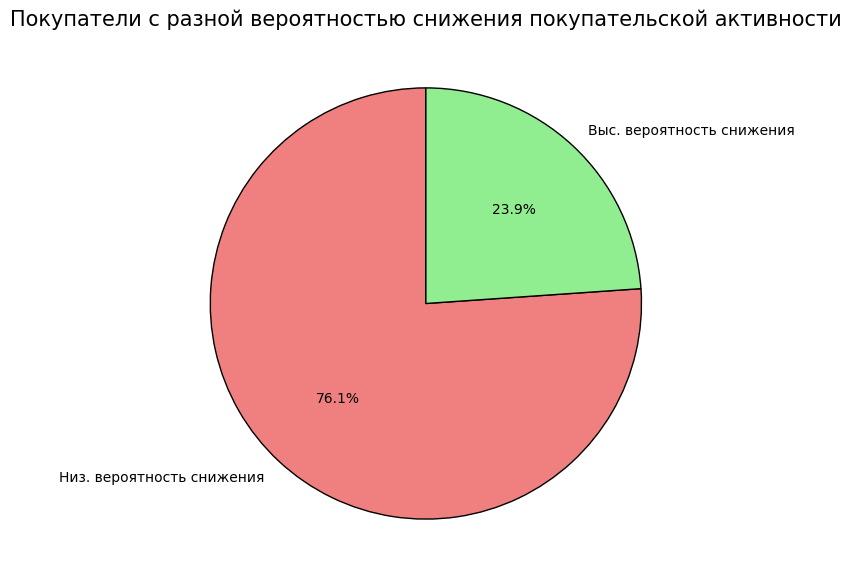

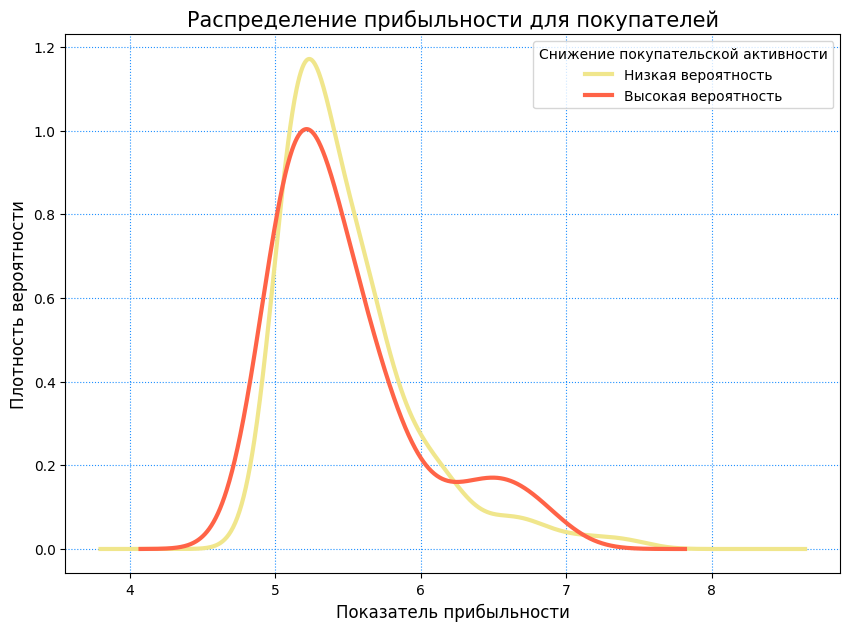

In [90]:
(df_combined[df_combined['прибыль'] > 5]['прогноз_покуп_активности']
 .value_counts()
 .plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'], 
       wedgeprops={'edgecolor': 'black'}, figsize=(7, 7)))
plt.title('Покупатели с разной вероятностью снижения покупательской активности', size=15)
plt.ylabel('')
plt.show()

# Построение графиков плотности для прибыльности
ax = selected_segment_good['прибыль'].plot(
    kind='density', linewidth=3, label='Низкая вероятность', 
    figsize=(10, 7), color='khaki')

selected_segment['прибыль'].plot(
    kind='density', linewidth=3, ax=ax, color='tomato', label='Высокая вероятность')

plt.grid(linestyle='dotted', color='dodgerblue')
plt.title('Распределение прибыльности для покупателей', size=15)
plt.xlabel('Показатель прибыльности', size=12)
plt.ylabel('Плотность вероятности', size=12)
plt.legend(title='Снижение покупательской активности')
plt.show()

Популярные категории в выбранном сегменте:
популярная_категория
Товары для детей                        17
Косметика и аксесуары                   15
Техника для красоты и здоровья           6
Кухонная посуда                          5
Домашний текстиль                        4
Мелкая бытовая техника и электроника     2
Name: count, dtype: int64
--------------------------------------------------
Типы сервиса в выбранном сегменте:
тип_сервиса
стандарт    28
премиум     21
Name: count, dtype: int64
--------------------------------------------------


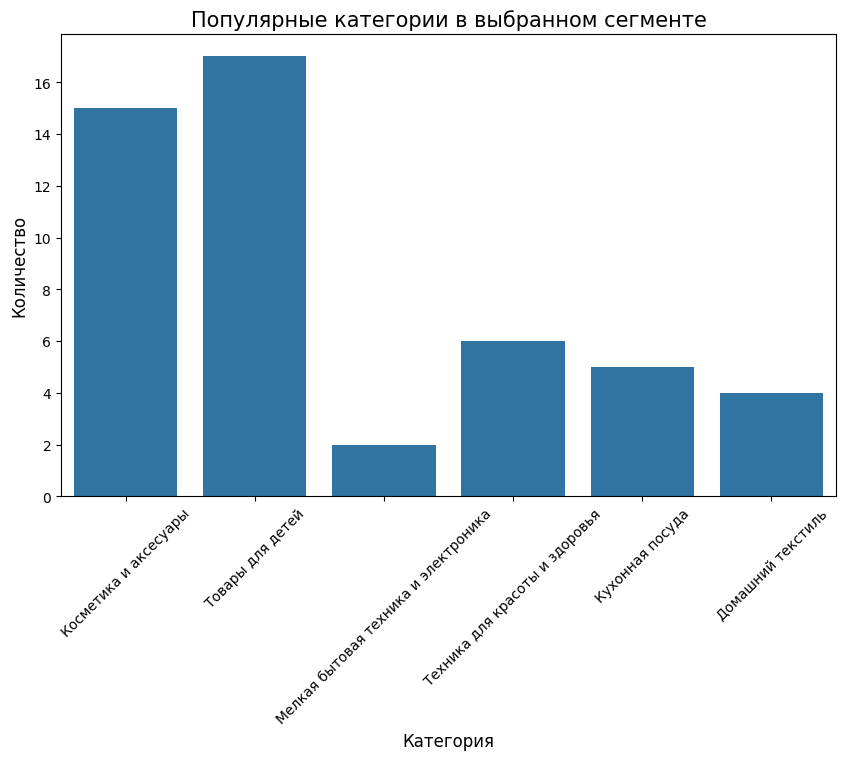

--------------------------------------------------


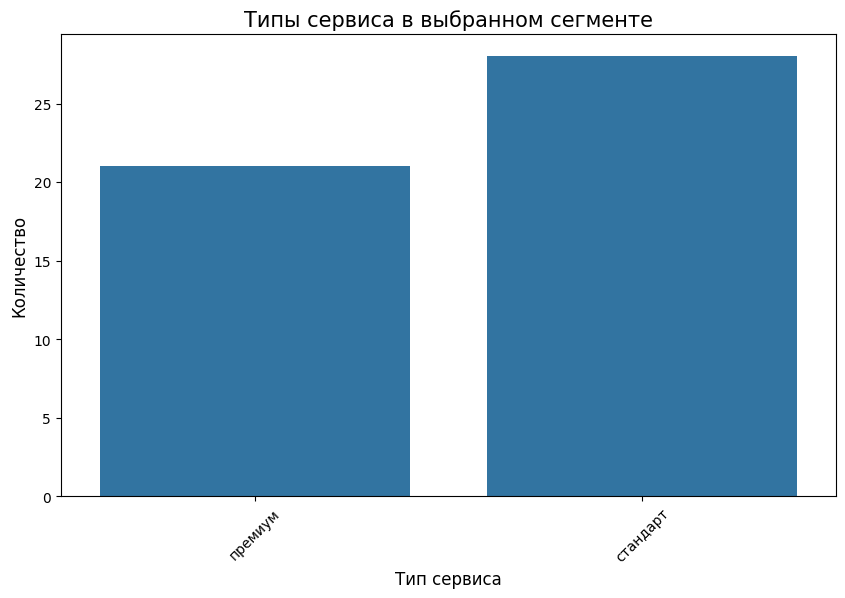

--------------------------------------------------


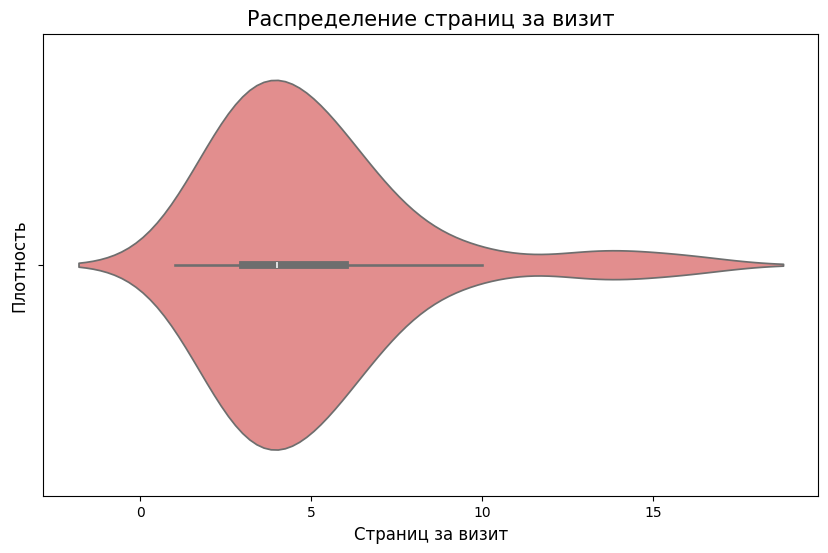

--------------------------------------------------


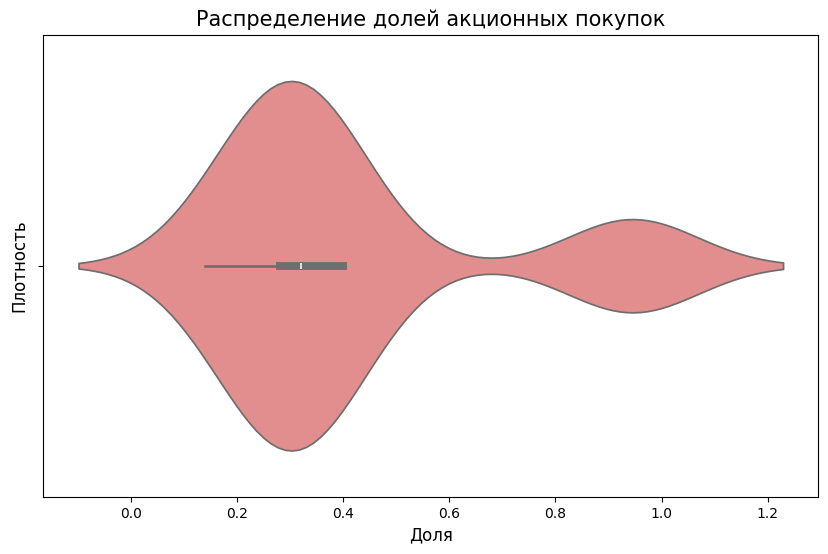

In [91]:
line_1 = '-' * 50

# Изучим популярные категории и типы сервиса
print('Популярные категории в выбранном сегменте:')
print(selected_segment['популярная_категория'].value_counts())
print(line_1)
print('Типы сервиса в выбранном сегменте:')
print(selected_segment['тип_сервиса'].value_counts())
print(line_1)

# Функция для построения barplot
def plot_barplot(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=data, hue=None)  # Убираем `palette` или указываем `hue=None`
    plt.title(title, size=15)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.xticks(rotation=45)
    plt.show()

# Функция для построения violin plot
def plot_violinplot(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=data[column], color='lightcoral')
    plt.title(title, size=15)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

# Barplot для популярной категории
plot_barplot(selected_segment, 'популярная_категория', 
             title='Популярные категории в выбранном сегменте', xlabel='Категория', ylabel='Количество')

print(line_1)

# Barplot для типа сервиса
plot_barplot(selected_segment, 'тип_сервиса', 
             title='Типы сервиса в выбранном сегменте', xlabel='Тип сервиса', ylabel='Количество')

print(line_1)

# Violin plot для страниц за визит
plot_violinplot(selected_segment, 'страниц_за_визит', 
                title='Распределение страниц за визит', xlabel='Страниц за визит', ylabel='Плотность')

print(line_1)

# Violin plot для доли акционных покупок
plot_violinplot(selected_segment, 'акционные_покупки', 
                title='Распределение долей акционных покупок', xlabel='Доля', ylabel='Плотность')

В результате анализа сегмента был выделен сегмент с высокой прибыльностью и высокой вероятностью снижения покупательской активности. Изучены предпочтения покупателей по категориям, типы сервиса и доля акционных покупок.

Рекомендации для увеличения покупательской активности:
Популярные категории товаров:

Лидеры: «Товары для детей» (17 человек), «Косметика и аксессуары» (15 человек).
Дополнительно: «Техника для красоты и здоровья» (6 человек), «Кухонная посуда» (5 человек), «Домашний текстиль» (4 человека).
Предложение:
Персонализированные скидки и промокоды на популярные категории.
Выделение этих категорий на главной странице или в e-mail рассылках.
Типы сервиса:

Стандартный сервис: 28 покупателей.
Премиум сервис: 21 покупатель.
Предложение:
Для премиум-пользователей — скидки на обслуживание, чтобы повысить лояльность.
Для пользователей стандартного сервиса — привлекательные условия для перехода на премиум (например, первый месяц бесплатно или со скидкой).
Удержание пользователей:

Внедрение персонализированных всплывающих окон на сайте.
Рекомендации товаров из категорий «Косметика и аксессуары» и «Товары для детей» для их активного продвижения.
Эти меры направлены на стимулирование роста покупательской активности и улучшение удержания клиентов, что, в свою очередь, положительно скажется на прибыли компании.

## Шаг 9. Общий вывод

- Цель проекта — разработать эффективное решение для интернет-магазина «В один клик», направленное на увеличение покупательской активности постоянных клиентов с помощью персонализированных предложений. Основная задача заключалась в прогнозировании вероятности снижения покупательской активности клиентов в течение ближайших трёх месяцев.

- Исходные данные и предобработка:
Для анализа использовались четыре набора данных: market_file.csv, market_money.csv, market_time.csv и money.csv. На этапе предобработки были устранены опечатки, удалены аномалии, объединены таблицы, а также проведён исследовательский анализ данных.

- Поиск лучшей модели:
Для выбора наиболее эффективной модели использовали пайплан из четырех моделей: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier и SVС. Оценка качества моделей осуществлялась с использованием метрики ROC-AUC.

- Лучшая модель: LogisticRegression(penalty='l1', random_state=42, solver='liblinear'). Метрика лучшей модели на тренировочной выборке: 0.896 Метрика ROC-AUC на тестовой выборке: 0.916. 

- В ходе анализа клиентской базы был выделен сегмент покупателей, характеризующихся высокой прибыльностью и существенным риском снижения покупательской активности. Исследование данного сегмента включало анализ предпочтений по товарным категориям, типов обслуживания и склонности к акционным покупкам.

Рекомендации для увеличения активности клиентов:

Индивидуальные предложения:

Разработать промокоды на скидки для популярных категорий товаров, таких как кухонная посуда, товары для детей и домашний текстиль, чтобы стимулировать покупки.
Внедрить персонализированные всплывающие окна с релевантными рекомендациями, ориентированными на интересы клиентов.
Программы обслуживания:

Пользователям стандартного сервиса (31 клиент) предложить выгодные условия для перехода на премиум-обслуживание, включая временные акции или бонусы.
Для премиум-клиентов (23 человека) внедрить скидки на продление премиального пакета или улучшение текущего уровня обслуживания.
Таргетинг по категориям товаров:

Покупателям, предпочитающим категории «Косметика и аксессуары» и «Товары для детей» (по 15 человек в каждой), предложить эксклюзивные скидки и акции.
Акцентировать внимание на этих категориях в индивидуальных рекомендациях и продвижении товаров на сайте.
Эти меры помогут удержать клиентов, повысить их вовлеченность и стимулировать рост покупательской активности, укрепив лояльность к интернет-магазину.